In [57]:
pip install torch==1.13.0+cu121 torchvision==0.14.0+cu118 torchaudio==0.13.0 --extra-index-url https://download.pytorch.org/whl/cu118

Looking in indexes: https://pypi.org/simple, https://download.pytorch.org/whl/cu118
Note: you may need to restart the kernel to use updated packages.


ERROR: Could not find a version that satisfies the requirement torch==1.13.0+cu118 (from versions: 1.11.0, 1.12.0, 1.12.1, 1.13.0, 1.13.1, 2.0.0, 2.0.0+cu118, 2.0.1, 2.0.1+cu118, 2.1.0, 2.1.0+cu118, 2.1.1, 2.1.1+cu118, 2.1.2, 2.1.2+cu118, 2.2.0, 2.2.0+cu118, 2.2.1, 2.2.1+cu118, 2.2.2, 2.2.2+cu118, 2.3.0, 2.3.0+cu118, 2.3.1, 2.3.1+cu118)
ERROR: No matching distribution found for torch==1.13.0+cu118

[notice] A new release of pip is available: 23.0.1 -> 24.1.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [1]:
import matplotlib
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torch.utils.data import Dataset, DataLoader, Subset
from torch.autograd import Variable

import torchvision
import torchvision.transforms as transforms

from sklearn.model_selection import train_test_split

import numpy as np
import os
from PIL import Image
import cv2
import random
import sys

In [2]:
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [3]:
# cuda 사용 가능 여부 확인
torch.cuda.is_available()

True

In [4]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

print("Current Device : {}".format(device))


Current Device : cuda


In [5]:
torch.cuda.get_device_name(device)

'NVIDIA GeForce RTX 3070'

In [6]:
torch.cuda.current_device()

0

In [7]:
# 시드 고정
def set_random_seed(seed):
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    torch.backends.cudnn.benchmark = True
    torch.backends.cudnn.deterministic = True
set_random_seed(7777)

In [8]:
# 파일 경로명 지정
file_dir = "./colab/colab/"

In [9]:
def target_to_oh(target):
    NUM_CLASS = 2  # hard code here, can do partial
    one_hot = torch.eye(NUM_CLASS)[target]
    return one_hot

In [10]:
# 데이터 전처리 및 DataSet 만들기(사전에 디렉토리 나누기 필수)
train_dir = os.path.join(file_dir + "train/")
test_dir = os.path.join(file_dir + "test/")

train_trans = transforms.Compose([
    #transforms.Resize((224, 224)),
    transforms.Resize((300, 300)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.Grayscale(),
    transforms.ToTensor(),
    transforms.Normalize((0.5, ), (0.5,))
])

test_trans = transforms.Compose([
    transforms.Resize((300, 300)),
    transforms.Grayscale(),
    transforms.ToTensor(),
    transforms.Normalize((0.5, ), (0.5,))

])

trainset = torchvision.datasets.ImageFolder(root = train_dir, transform = train_trans, target_transform = target_to_oh)
testset = torchvision.datasets.ImageFolder(root = test_dir, transform = test_trans)

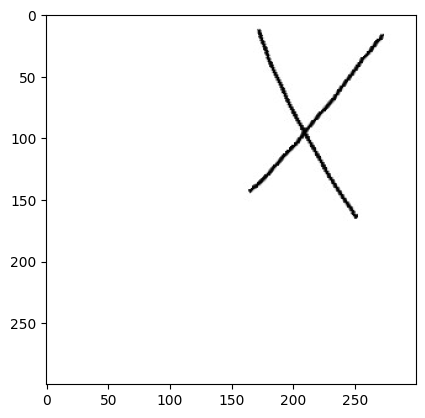

In [11]:
# 데이터셋 테스트, 가장 첫번째 이미지 불러오기(train\o\o_1.png)
plt.imshow(transforms.ToPILImage()(trainset[130][0]), cmap='gray')

In [12]:
testset[50][1]

1

In [13]:
# HyperParameter
n_batch = 16

# DataLoader 만들기
trainloader = DataLoader(trainset, batch_size = n_batch, shuffle = True, num_workers = 0)
testloader = DataLoader(testset, batch_size = n_batch, shuffle = True, num_workers = 0) # 사전에 랜덤으로 섞어놓은 상태라 테스트셋 셔플이 의미가 있나 싶지만.. 그래도

In [14]:
# train 데이터셋을 batch 단위로 순회하는 iterator
it = iter(trainloader)

클래스: ['o', 'x']
데이터셋 크기: 56


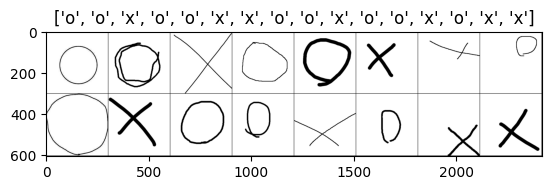

torch.Size([1, 300, 300])


In [15]:
# 현재 batch 꺼내보기(연속으로 실행 시 다음 batch로 이동)
img, label = next(it) # 다음 순서로 넘어감
def imshow(input, title):
    # torch.Tensor를 numpy 객체로 변환
    input = input.numpy().transpose((1, 2, 0))
    # 이미지 정규화 해제하기
    #mean = np.array([0.43303847, 0.4034577, 0.39415097])
    #std = np.array([0.18344551, 0.17549995, 0.1647388])
    #input = std * input + mean
    input = np.clip(input, 0, 1)

    # 이미지 출력
    plt.imshow(input)
    plt.title(title)
    plt.show()


class_names = testset.classes
print('클래스:', class_names)

out = torchvision.utils.make_grid(img)
print('데이터셋 크기:', len(testset))

imshow(out, title=[class_names[int(y)] for x, y in label.tolist()])
#imshow(out, title=[class_names[x] for x in label])

print(img[0].shape)

In [16]:
label

tensor([[1., 0.],
        [1., 0.],
        [0., 1.],
        [1., 0.],
        [1., 0.],
        [0., 1.],
        [0., 1.],
        [1., 0.],
        [1., 0.],
        [0., 1.],
        [1., 0.],
        [1., 0.],
        [0., 1.],
        [1., 0.],
        [0., 1.],
        [0., 1.]])

In [17]:
# nn.Linear 입력차원 계산
ks = (3, 3)

imgs, labels = next(iter(trainloader))
m = nn.Sequential(
    nn.Conv2d(in_channels = 1, out_channels = 16, kernel_size = ks, padding = "same"),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size = 2),
    nn.Conv2d(in_channels = 16, out_channels = 32, kernel_size = ks, padding = "same"),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size = 2),
    nn.Conv2d(in_channels = 32, out_channels = 64, kernel_size = ks, padding = "same"),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size = 2),
    nn.Conv2d(in_channels = 64, out_channels = 128, kernel_size = ks, padding = "same"),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size = 2)
    )
out = m(imgs)
print(imgs.shape)
out.shape

torch.Size([16, 1, 300, 300])


torch.Size([16, 128, 18, 18])

In [18]:
# CNN 모델 구성
ks = (3, 3)

class CNN1(nn.Module):
    def __init__(self):
        super(CNN1, self).__init__()
        self.conv1 = nn.Conv2d(in_channels = 1, out_channels = 16, kernel_size = ks, padding = "same")
        self.conv2 = nn.Conv2d(in_channels = 16, out_channels = 32, kernel_size = ks, padding = "same")
        self.conv3 = nn.Conv2d(in_channels = 32, out_channels = 64, kernel_size = ks, padding = "same")       
        self.conv4 = nn.Conv2d(in_channels = 64, out_channels = 128, kernel_size = ks, padding = "same")       
        
        self.pooling = nn.MaxPool2d(kernel_size = 2)
        
        self.fc1 = nn.Linear(128*18*18, 1024)
        self.fc2 = nn.Linear(1024, 2)

        self.relu = nn.ReLU()

        #self.dropout = nn.Dropout(0.25)
        self.dropout1 = nn.Dropout(0.4)

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.pooling(x)
        #x = self.dropout(x)
        
        x = self.conv2(x)
        x = self.relu(x)
        x = self.pooling(x)
        #x = self.dropout(x)
        
        x = self.conv3(x)
        x = self.relu(x)
        x = self.pooling(x)
        #x = self.dropout(x)
        
        x = self.conv4(x)
        x = self.relu(x)
        x = self.pooling(x)
        #x = self.dropout(x)
        
        
        x = torch.flatten(x, start_dim = 1)
        
        x = self.fc1(x)
        x = self.relu(x)
        x = self.dropout1(x)
        x = self.fc2(x)
        #x = self.relu(x)

        #CrossEntropyLoss에 기본으로 softmax 제공
        #x = F.log_softmax(x, dim = 1)
        return x

In [19]:
# 모델 구성 미리보기
from torchinfo import summary

m = CNN1()
summary(m, (32, 1, 300, 300))

Layer (type:depth-idx)                   Output Shape              Param #
CNN1                                     [32, 2]                   --
├─Conv2d: 1-1                            [32, 16, 300, 300]        160
├─ReLU: 1-2                              [32, 16, 300, 300]        --
├─MaxPool2d: 1-3                         [32, 16, 150, 150]        --
├─Conv2d: 1-4                            [32, 32, 150, 150]        4,640
├─ReLU: 1-5                              [32, 32, 150, 150]        --
├─MaxPool2d: 1-6                         [32, 32, 75, 75]          --
├─Conv2d: 1-7                            [32, 64, 75, 75]          18,496
├─ReLU: 1-8                              [32, 64, 75, 75]          --
├─MaxPool2d: 1-9                         [32, 64, 37, 37]          --
├─Conv2d: 1-10                           [32, 128, 37, 37]         73,856
├─ReLU: 1-11                             [32, 128, 37, 37]         --
├─MaxPool2d: 1-12                        [32, 128, 18, 18]         --
├─L

In [20]:
# 훈련 함수

def train_loop(dataloader, model, loss_fn, optimizer, device):
    #onehot_y = []
    model.train() # 학습 모드
    for batch, (X, y) in enumerate(dataloader):
  
        X, y = X.to(device), y.to(device)
        #onehot_y.append( for x, y in )
        # 예측 오류 계산
        pred = model(X)
        loss = loss_fn(pred, y)

        # 역전파
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    return loss.item()



In [21]:
# 테스트 함수
def test_loop(dataloader, model, loss_fn, device):
    model.eval() # 평가 모드
    num_corr = 0
    test_loss, test_acc = 0.0,0.0
    class_names = testset.classes
    
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            
            pred = model(X)
            
            preds = pred.data.max(1)[1]
            corr = preds.eq(y.to(device).data).sum().item()
            num_corr += corr
            
            test_loss += loss_fn(pred,y)
            
            # 예측에 실패한 이미지 표기
            for i in range(n_batch):
                try:
                    if(preds[i] != y[i]):
                        plt.imshow(transforms.ToPILImage()(X[i][0]), cmap='gray')
                        plt.title(class_names[preds[i]])
                        plt.show()
                except:
                    pass
            #전체 과정 시각화
            #out = torchvision.utils.make_grid(X).to("cpu")
            #imshow(out, title=[x.item() for x in preds])
                
    
    test_loss /= len(dataloader) #step 수로 나누기.
    #test_acc /= len(dataloader.dataset) #총 데이터수로 나누기.
    test_acc = num_corr / len(dataloader.dataset)
    

    test_loss = round(float(test_loss), 4)
    test_acc = round(float(test_acc), 4)
      
    #print(f"Test loss: {test_loss}, Test accuracy: {test_acc * 100}%")
      
    return test_acc, test_loss

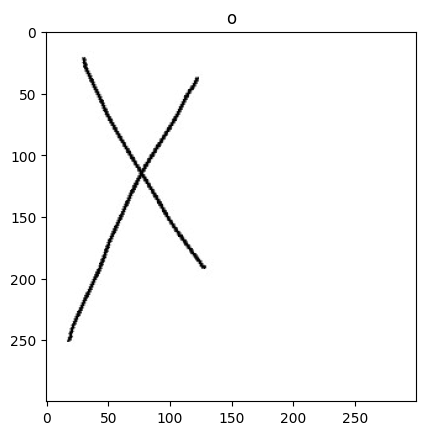

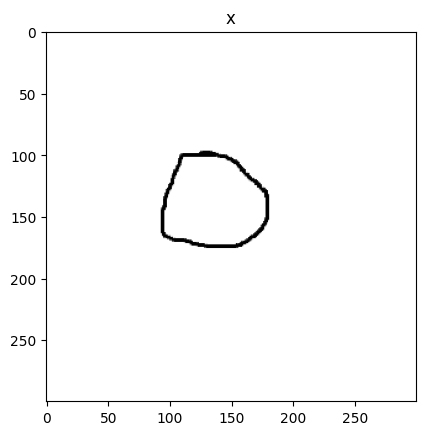

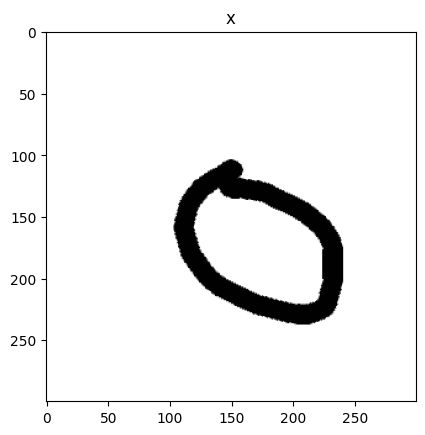

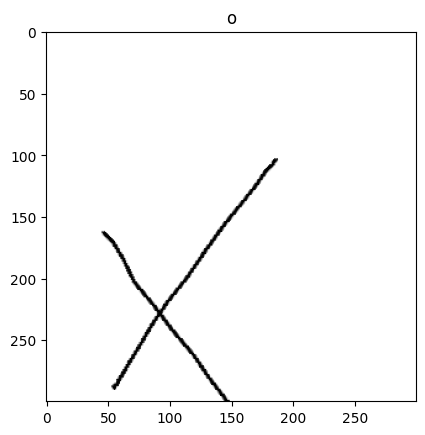

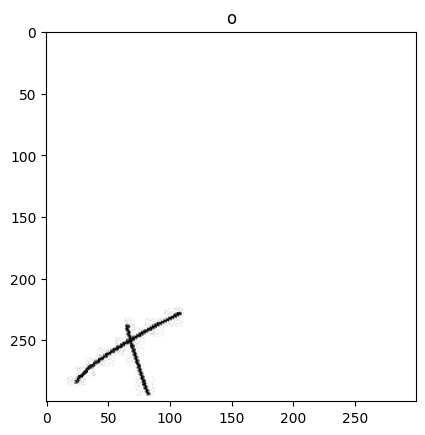

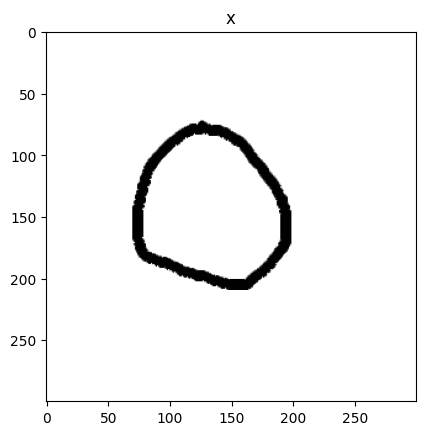

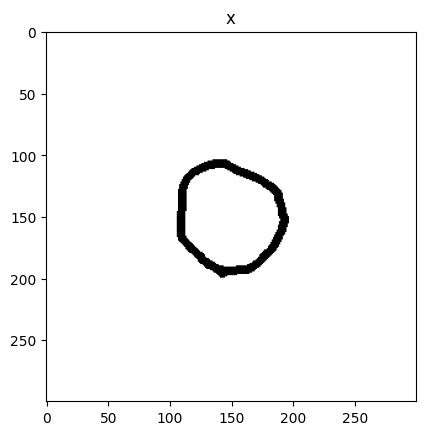

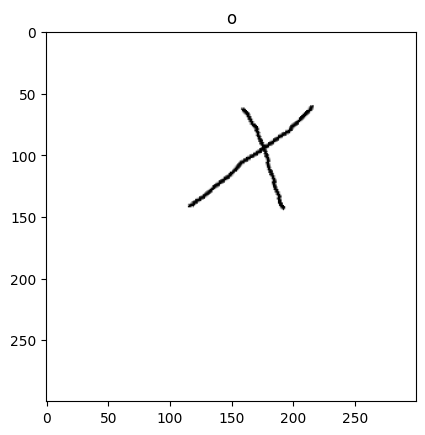

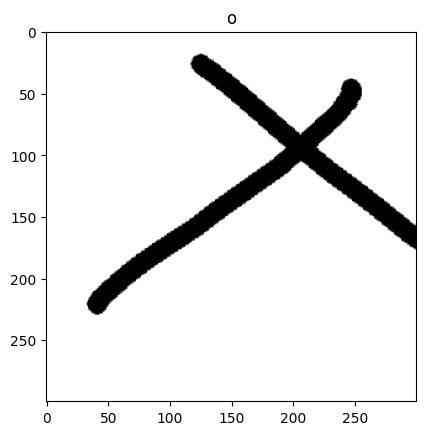

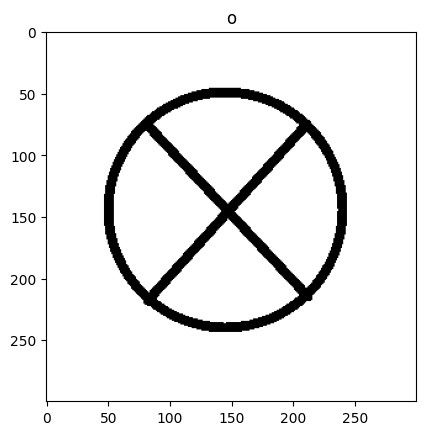

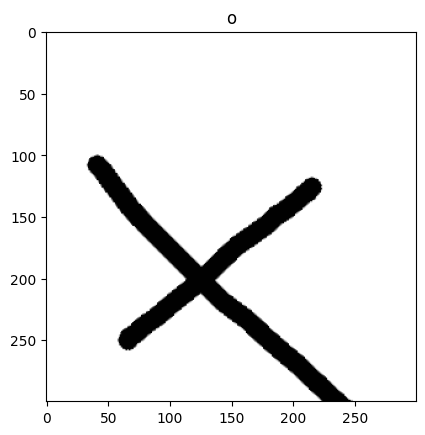

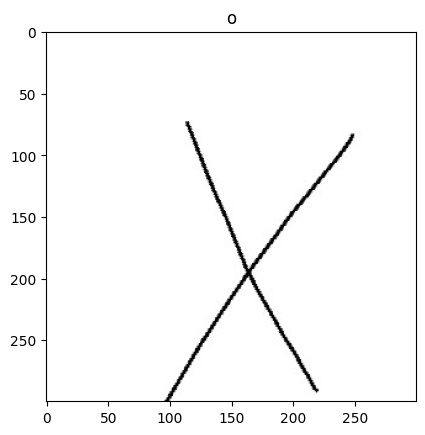

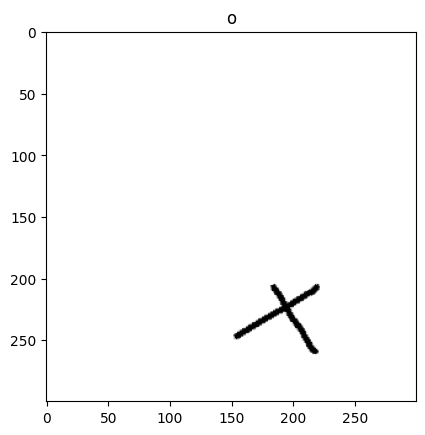

epoch(1 / 20)$ test_loss == 0.658, test_acc == 0.7679
loss 최저치 갱신, 현재 모델 저장, best_w_1.pth


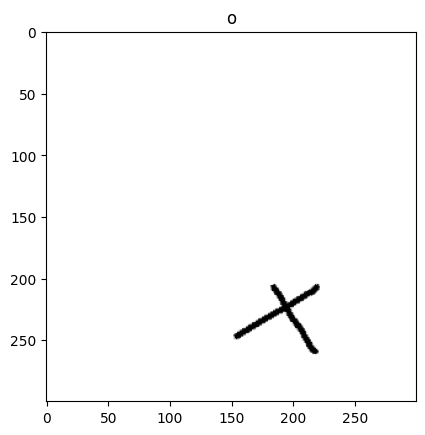

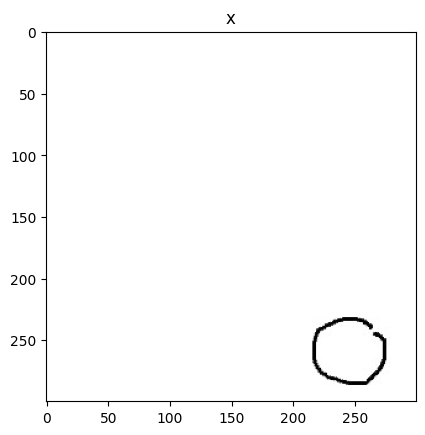

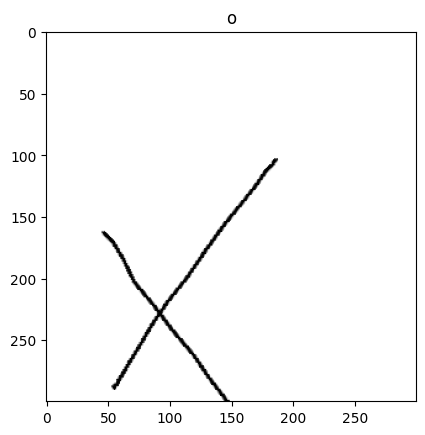

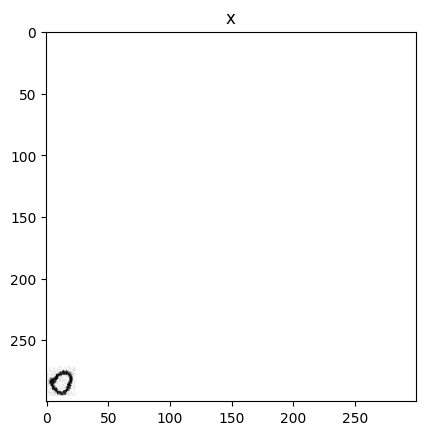

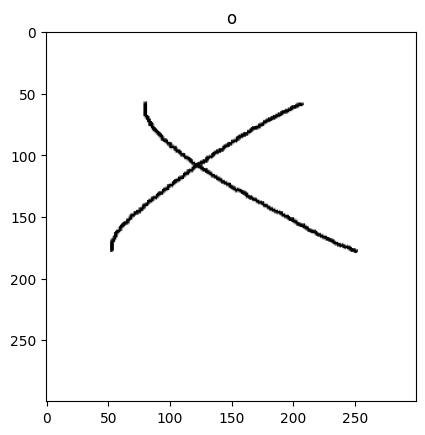

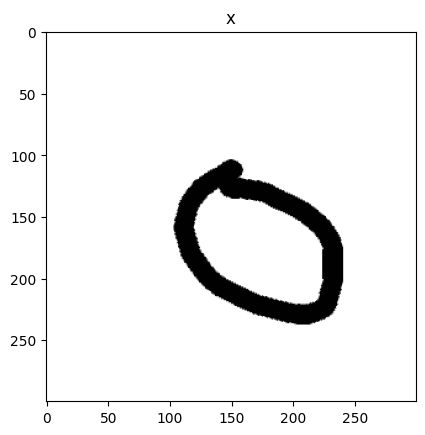

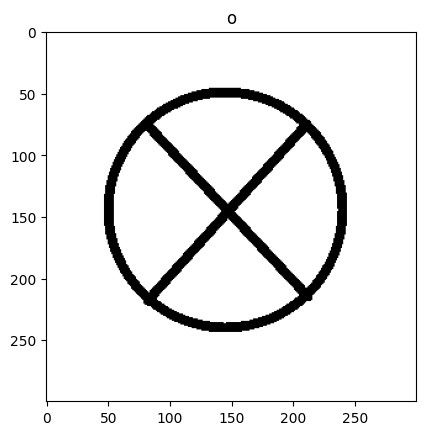

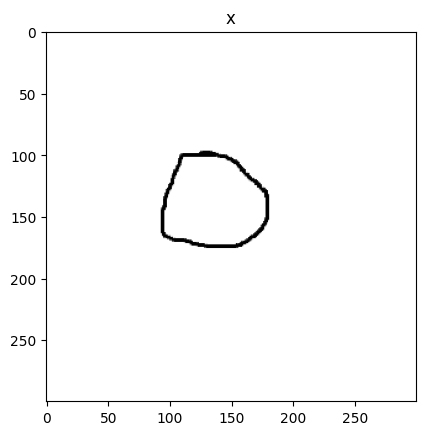

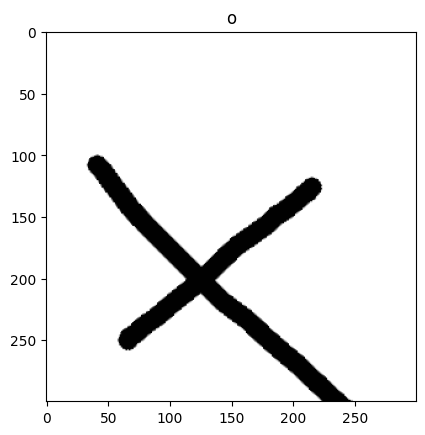

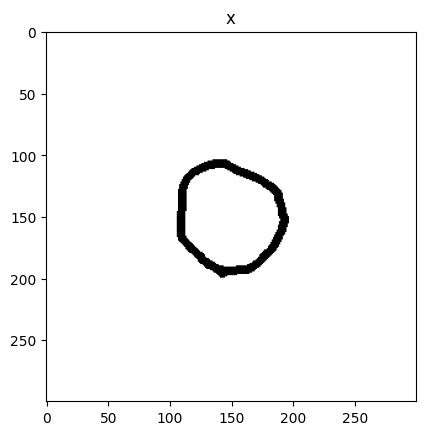

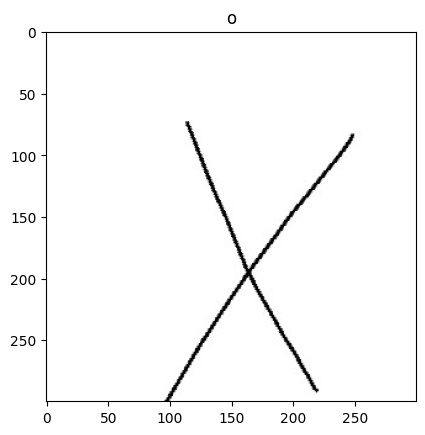

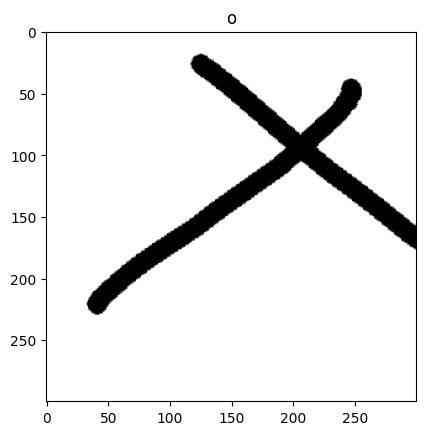

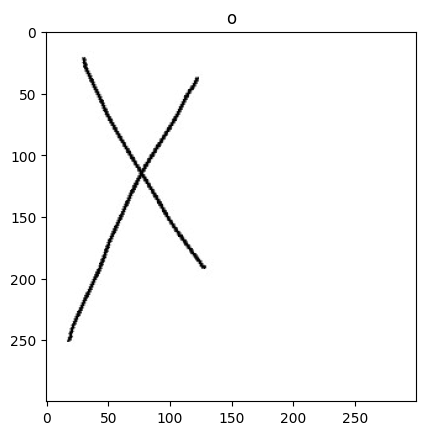

epoch(2 / 20)$ test_loss == 0.6804, test_acc == 0.7679


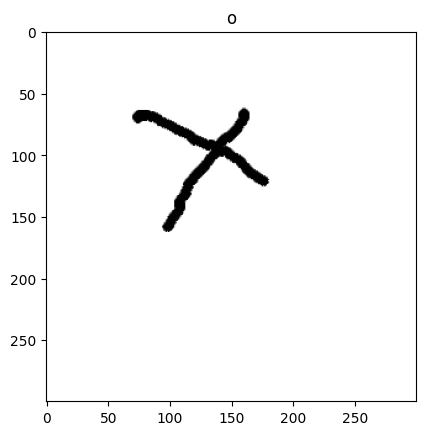

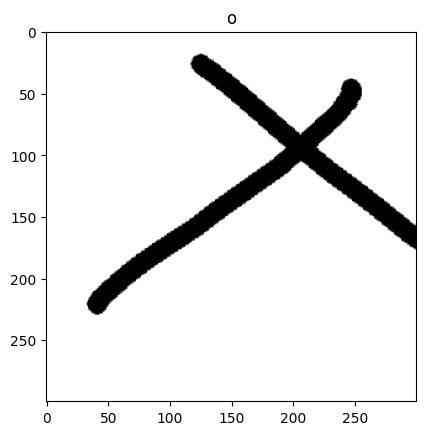

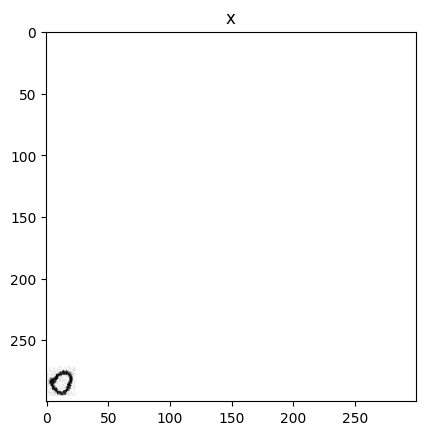

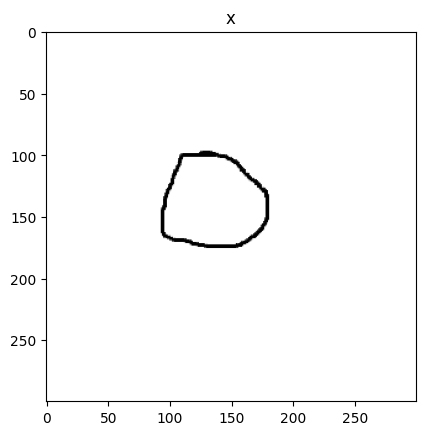

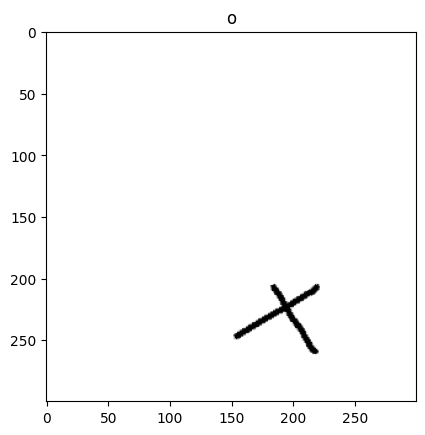

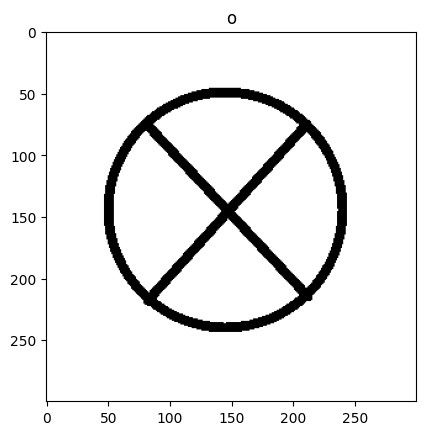

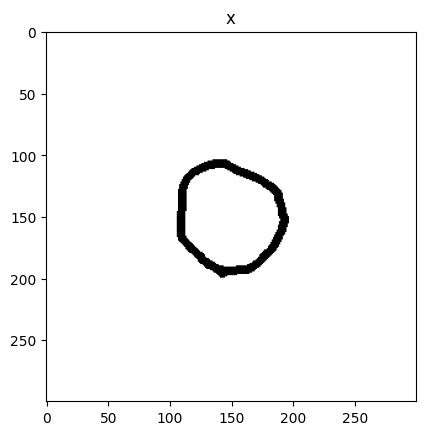

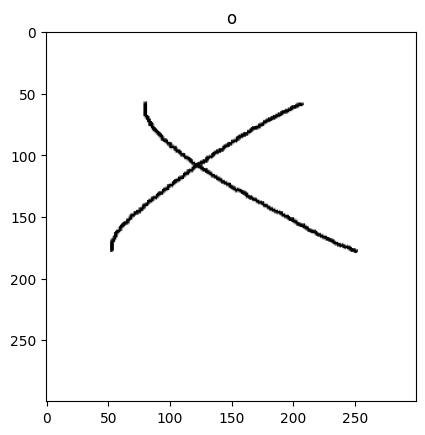

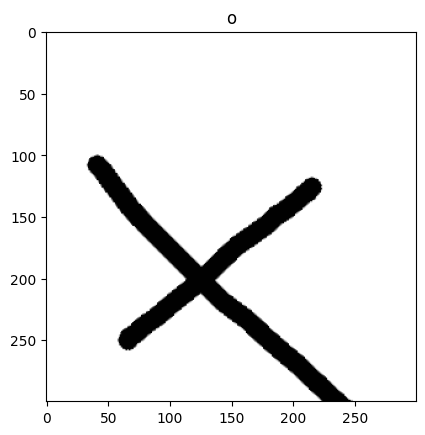

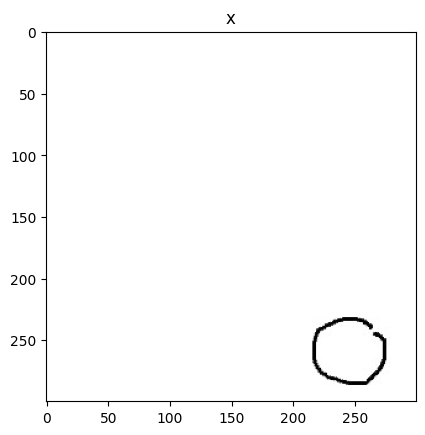

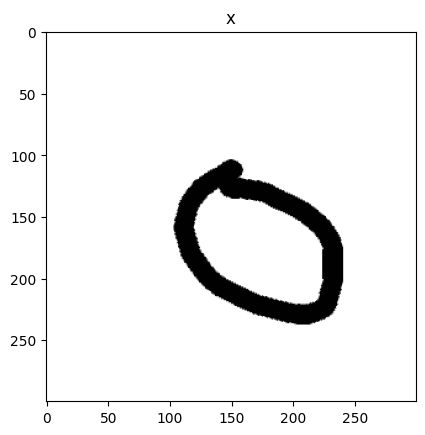

epoch(3 / 20)$ test_loss == 0.4715, test_acc == 0.8036
loss 최저치 갱신, 현재 모델 저장, best_w_3.pth


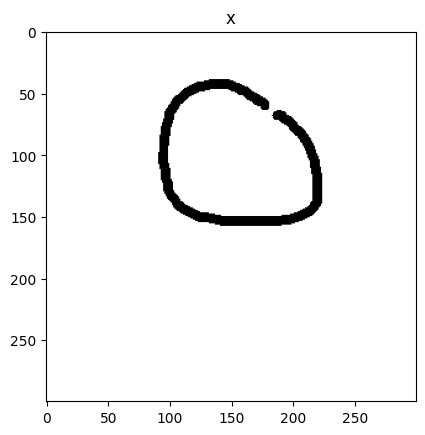

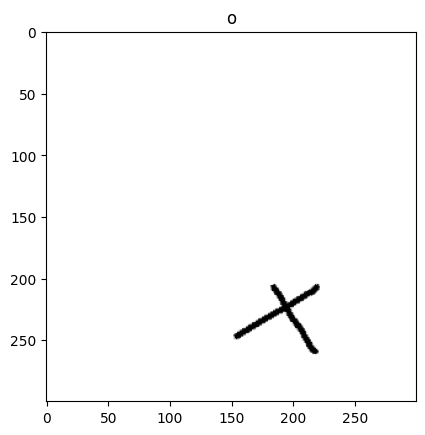

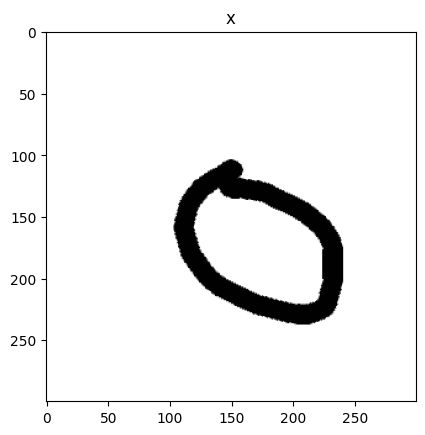

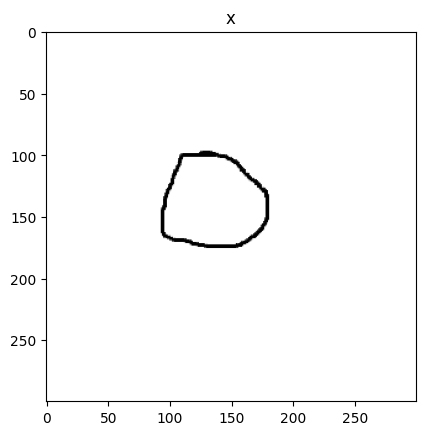

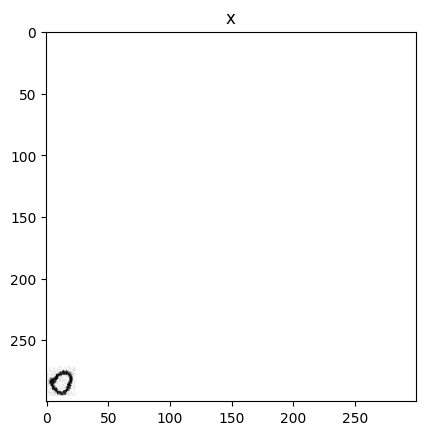

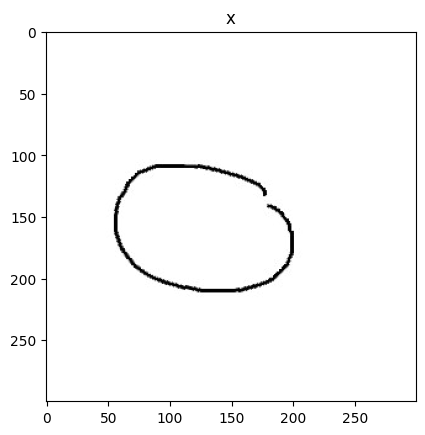

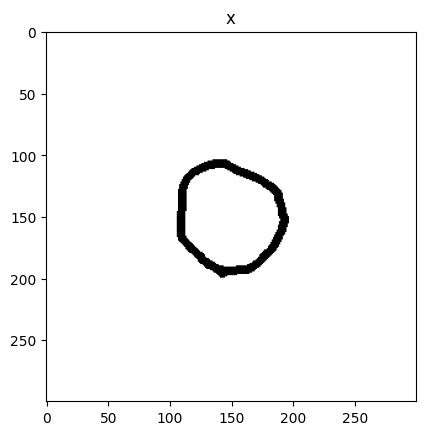

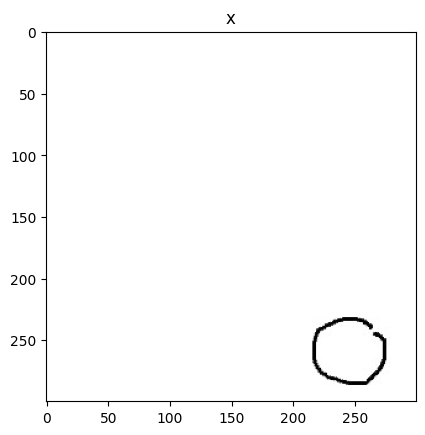

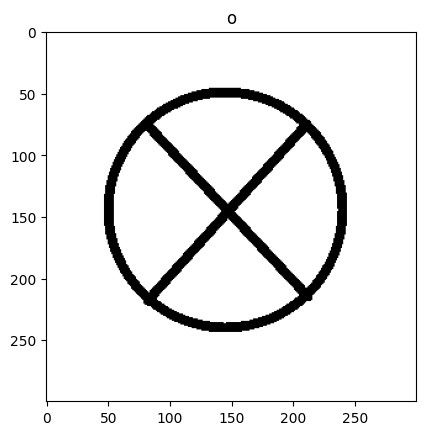

epoch(4 / 20)$ test_loss == 0.3955, test_acc == 0.8393
loss 최저치 갱신, 현재 모델 저장, best_w_4.pth


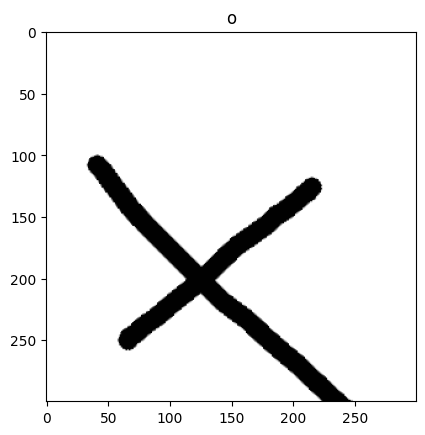

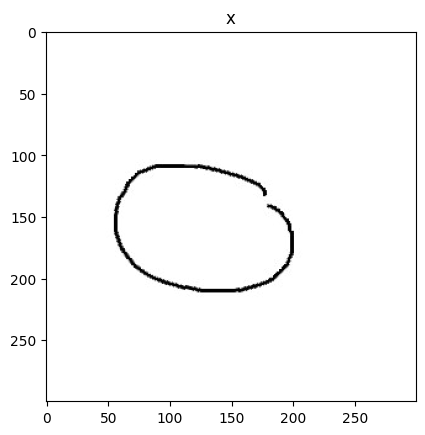

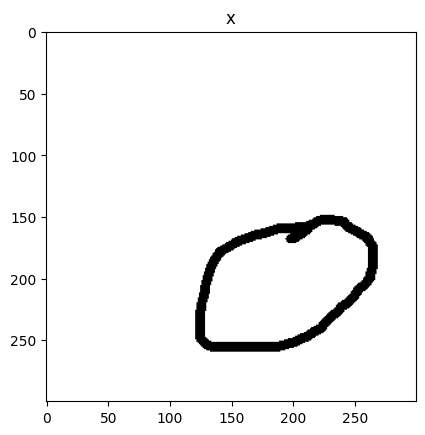

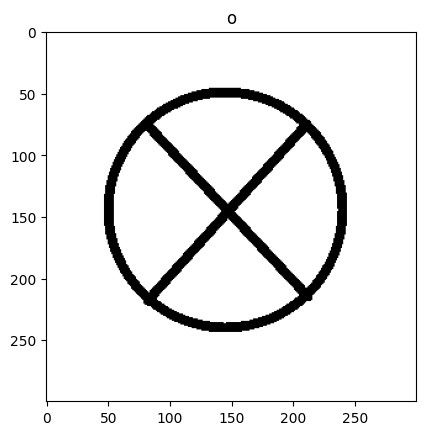

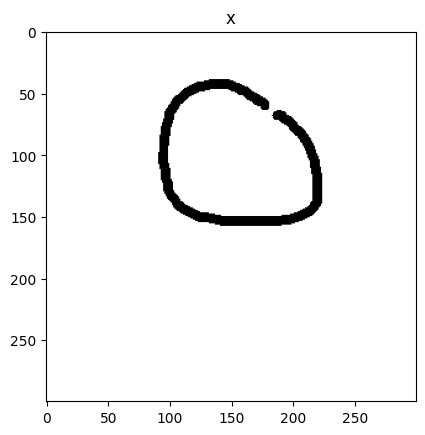

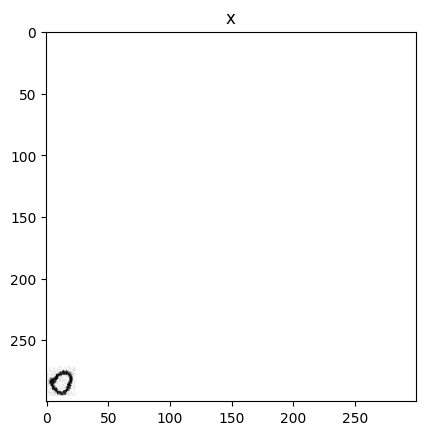

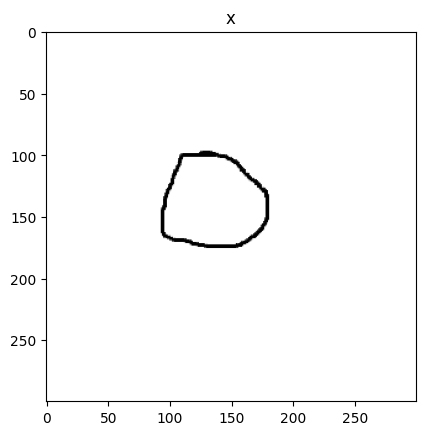

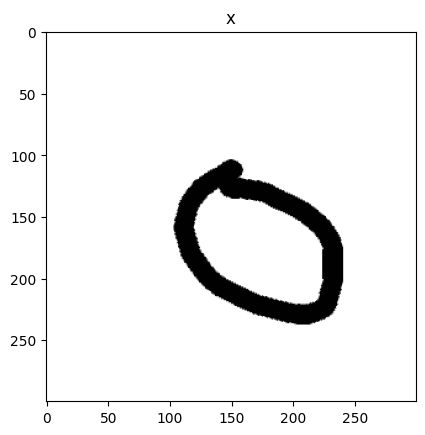

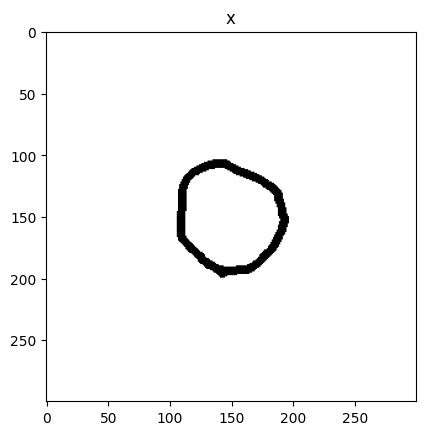

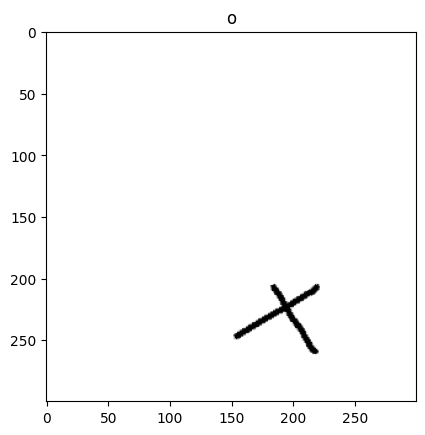

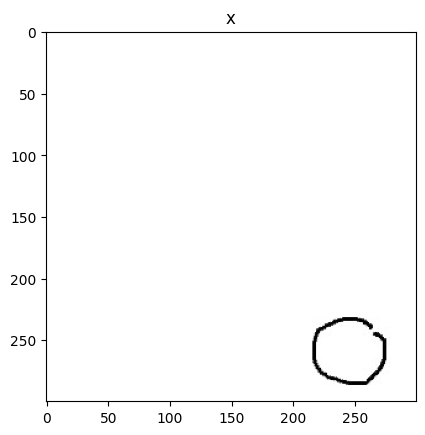

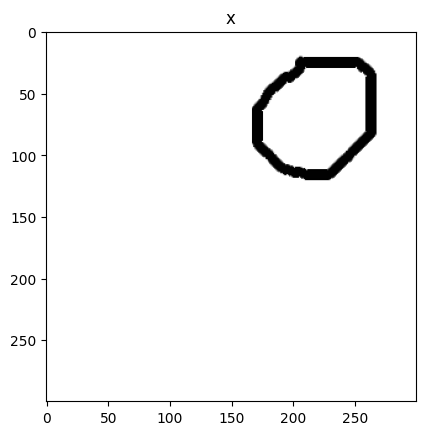

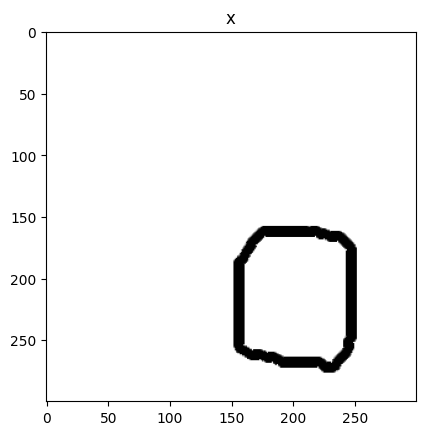

epoch(5 / 20)$ test_loss == 0.3779, test_acc == 0.7679
loss 최저치 갱신, 현재 모델 저장, best_w_5.pth


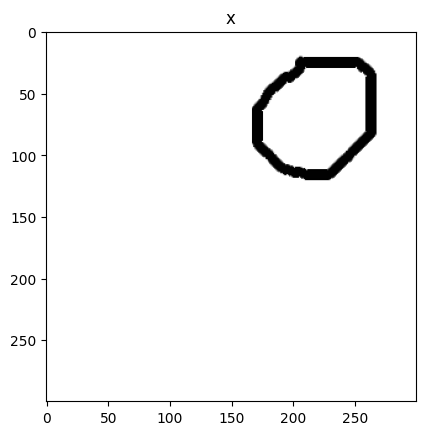

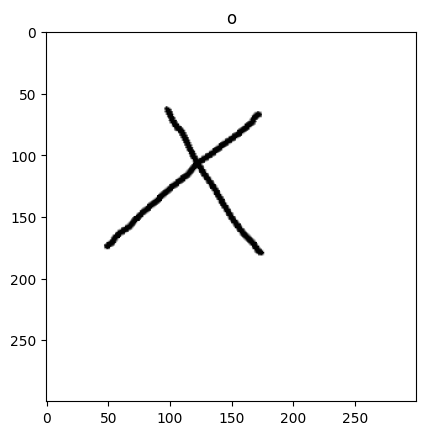

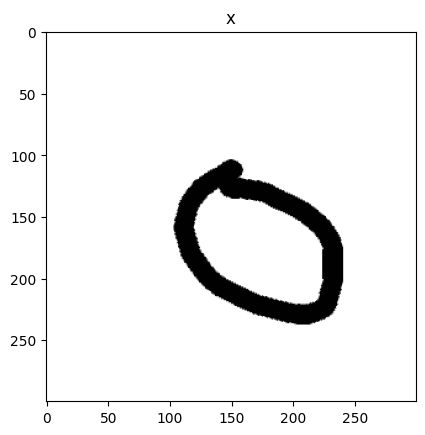

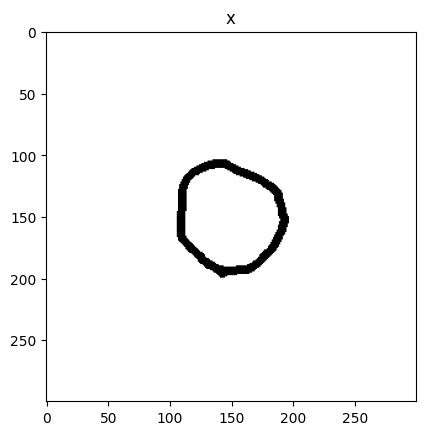

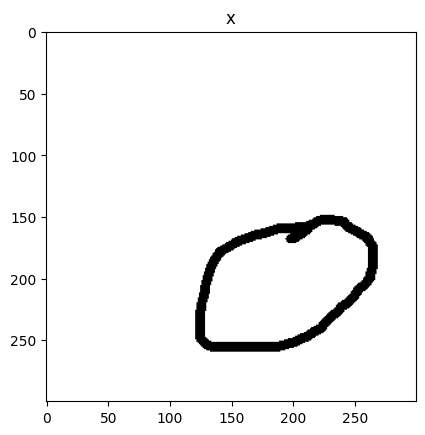

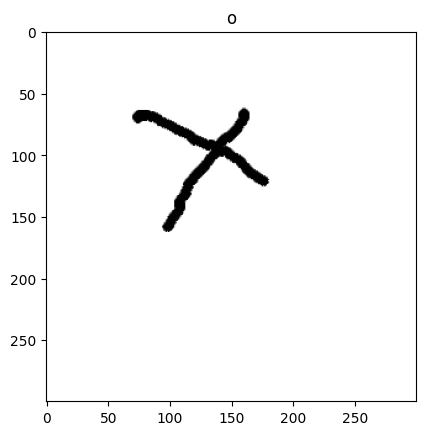

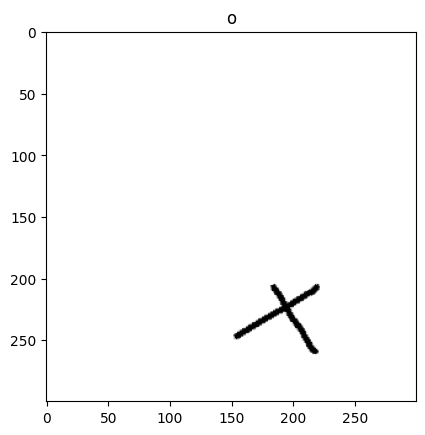

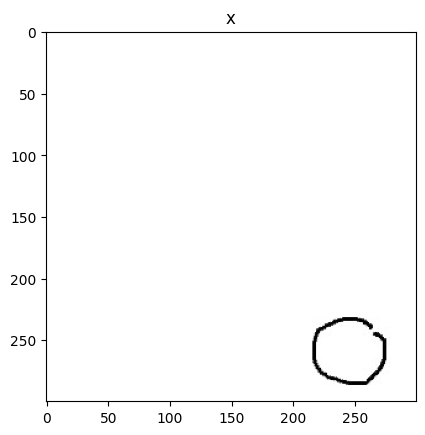

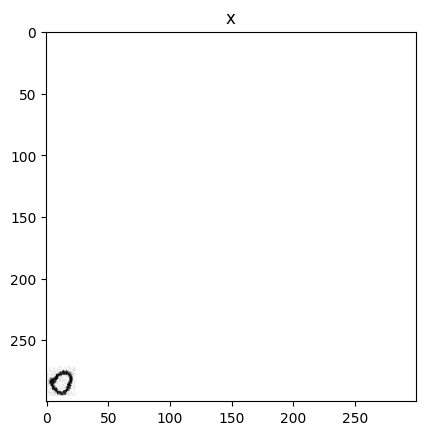

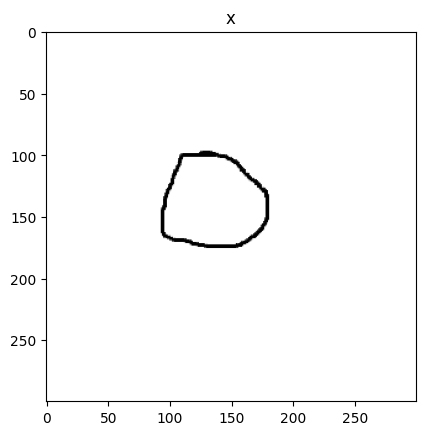

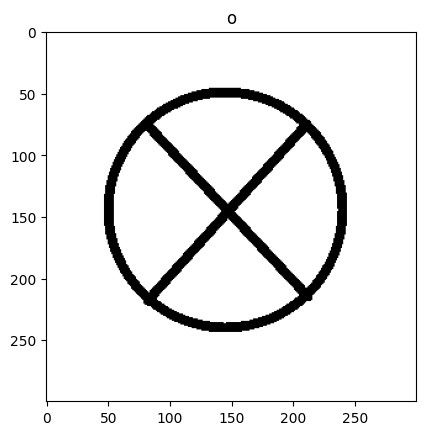

epoch(6 / 20)$ test_loss == 0.5153, test_acc == 0.8036


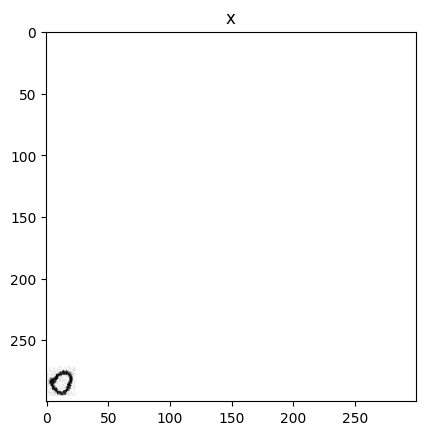

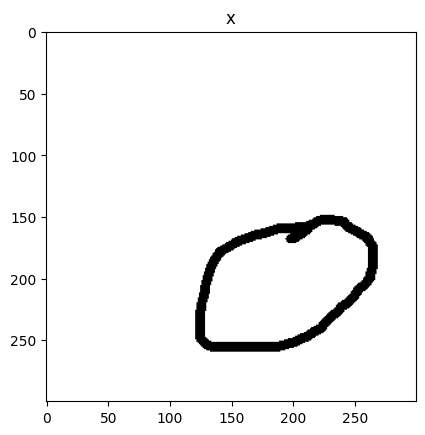

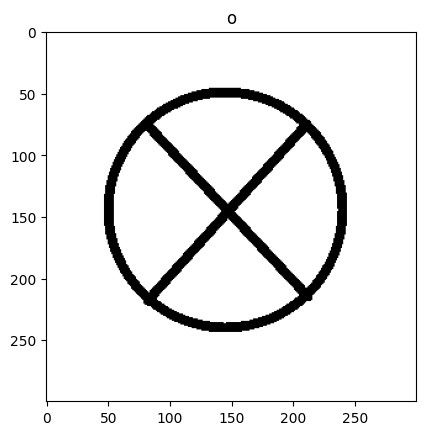

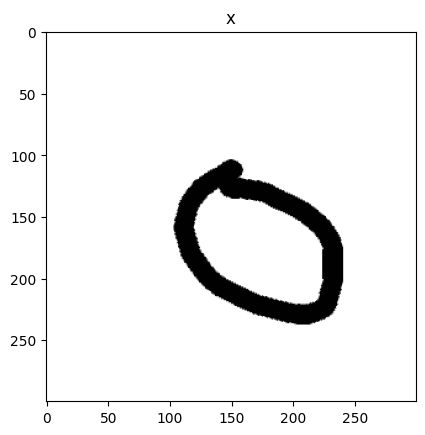

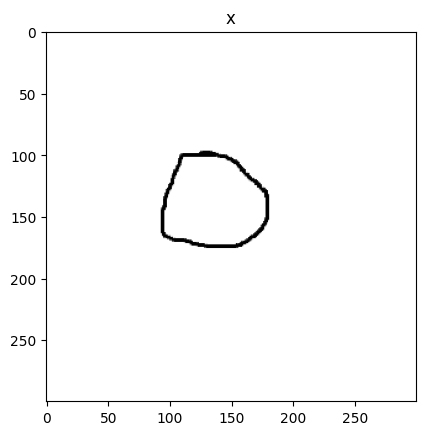

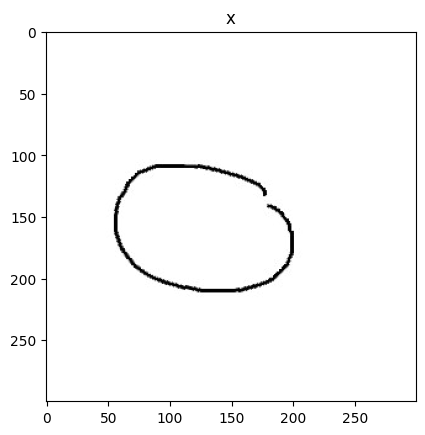

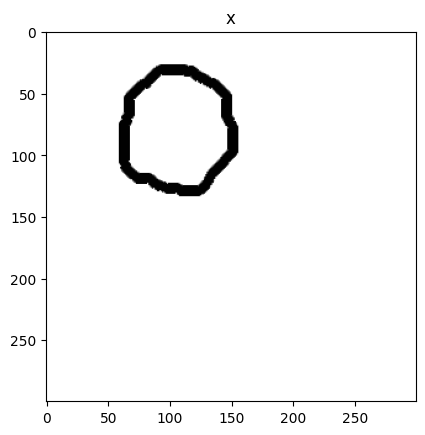

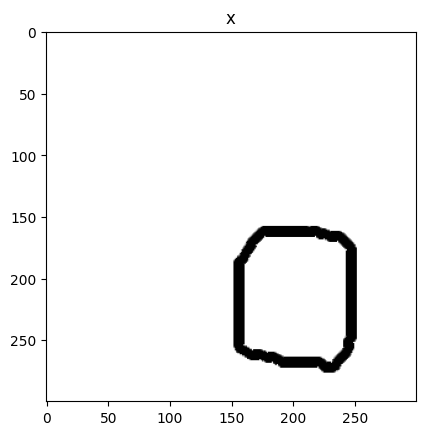

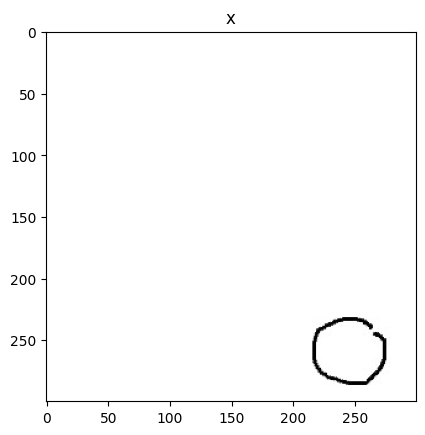

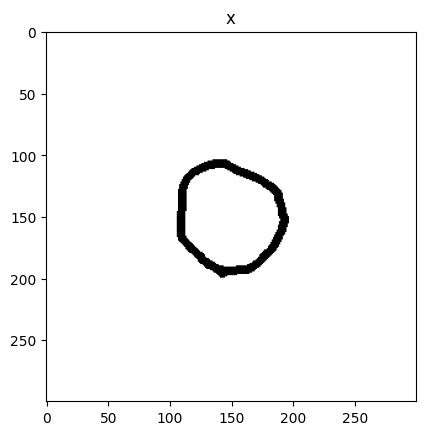

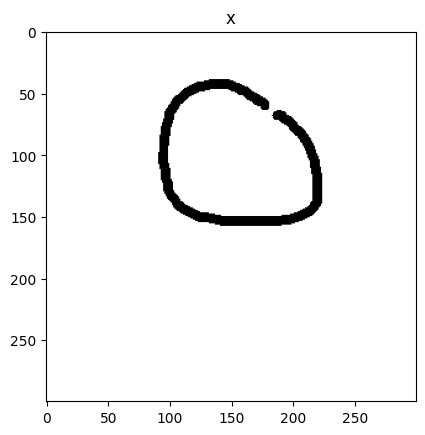

epoch(7 / 20)$ test_loss == 0.3902, test_acc == 0.8036


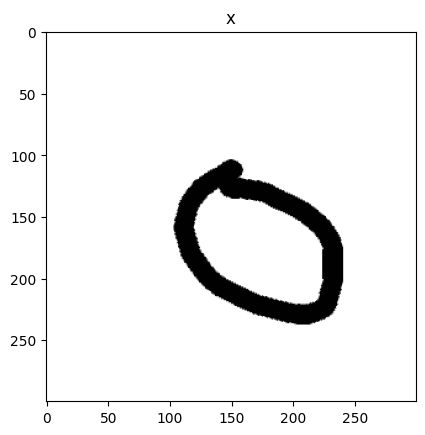

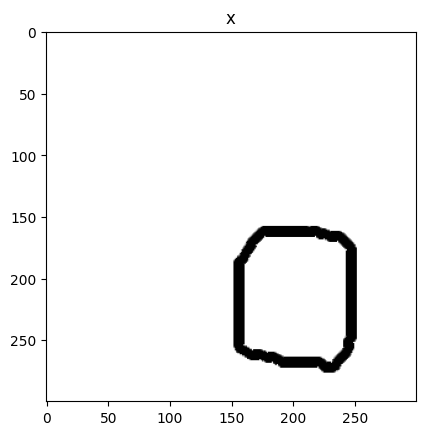

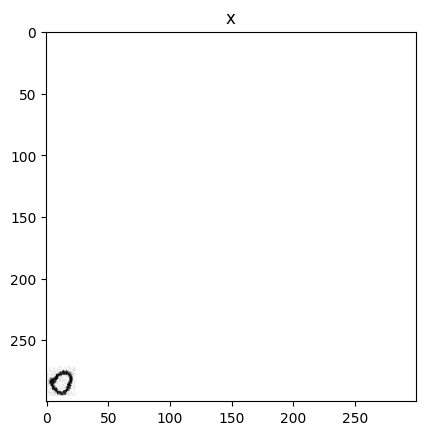

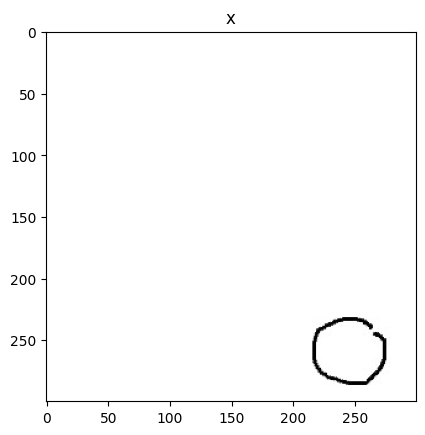

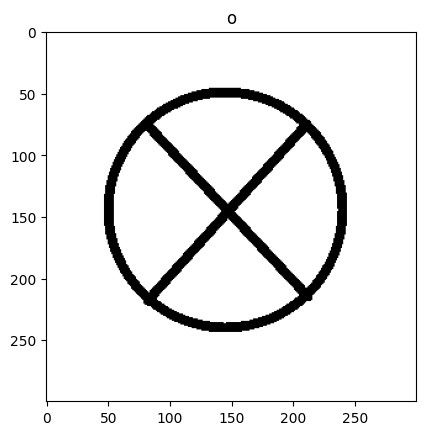

epoch(8 / 20)$ test_loss == 0.523, test_acc == 0.9107


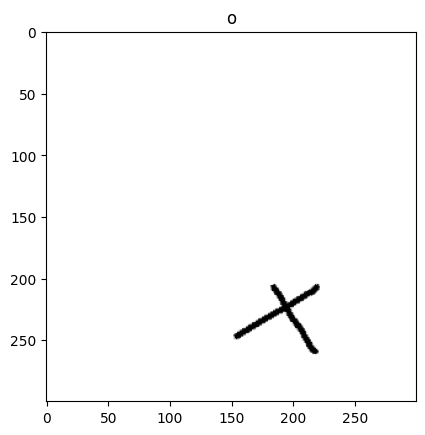

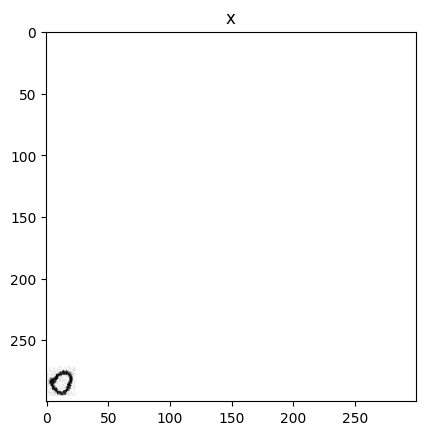

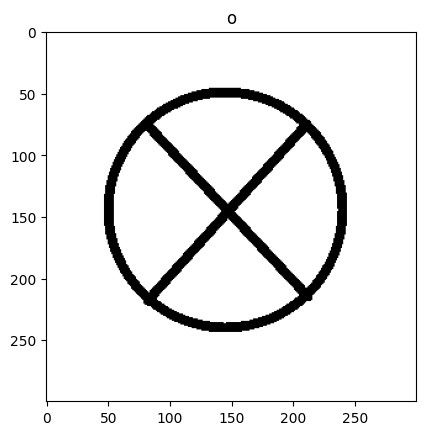

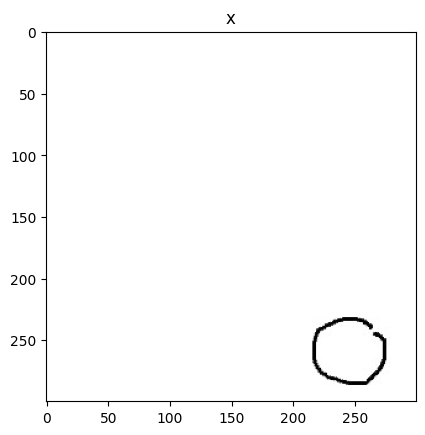

epoch(9 / 20)$ test_loss == 0.2228, test_acc == 0.9286
loss 최저치 갱신, 현재 모델 저장, best_w_9.pth


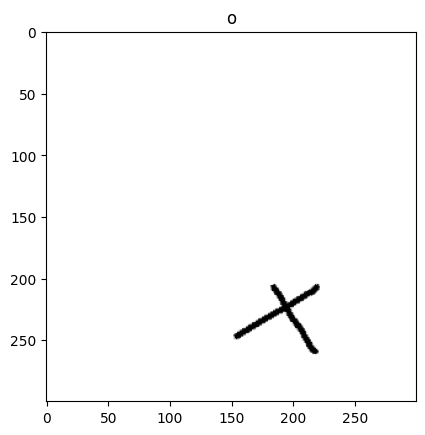

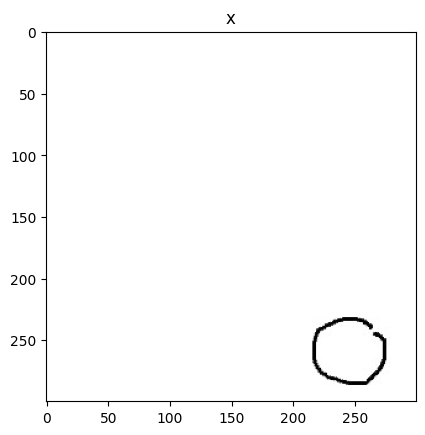

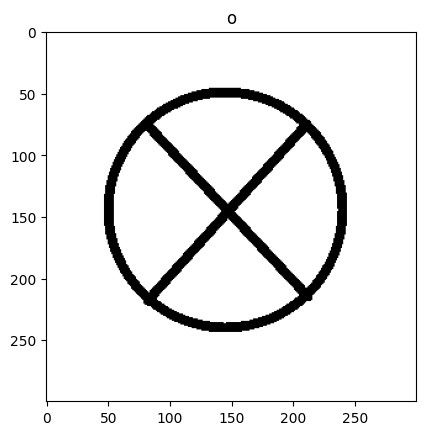

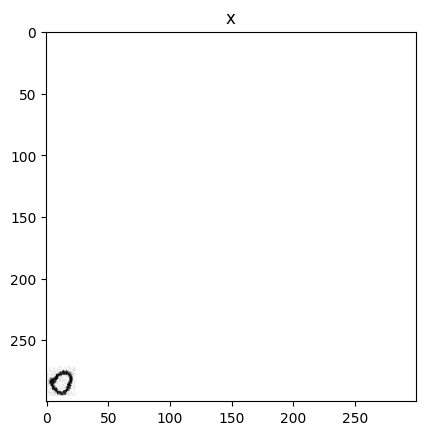

epoch(10 / 20)$ test_loss == 0.2408, test_acc == 0.9286


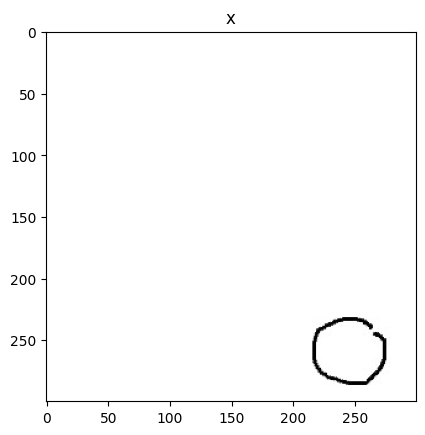

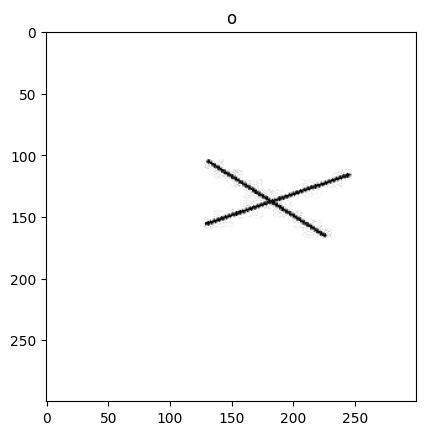

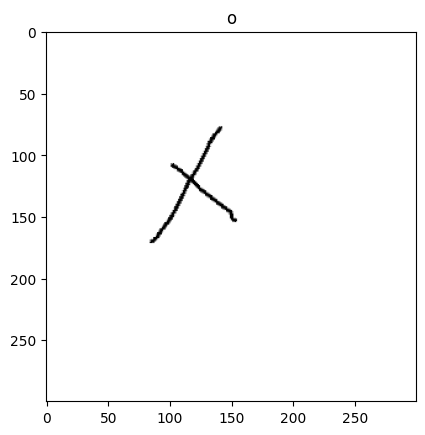

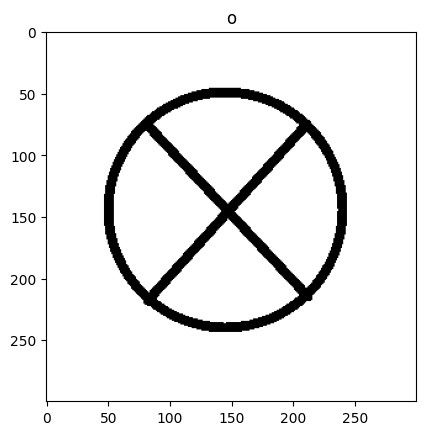

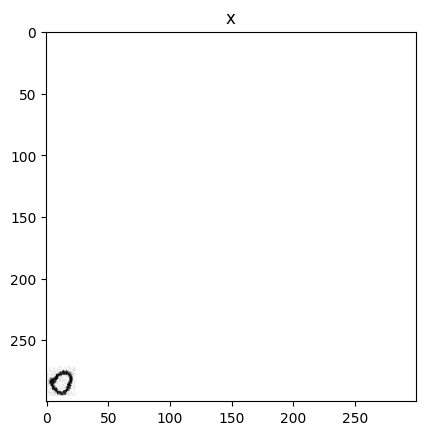

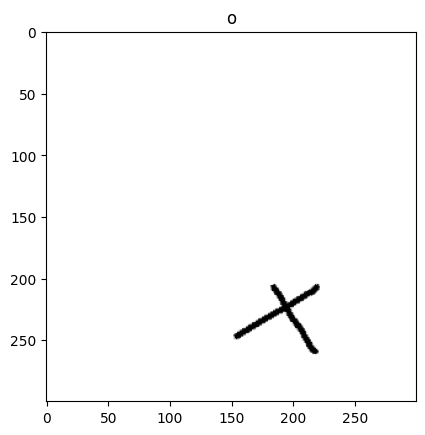

epoch(11 / 20)$ test_loss == 0.6322, test_acc == 0.8929


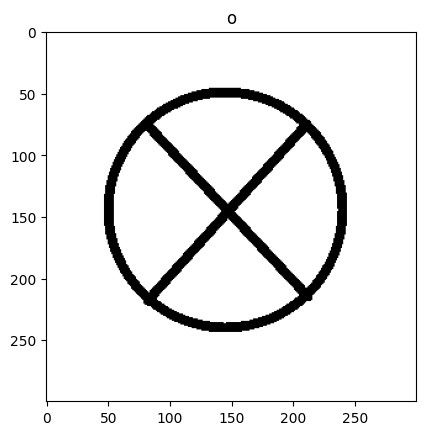

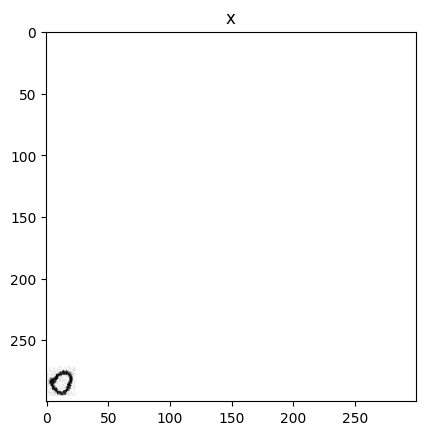

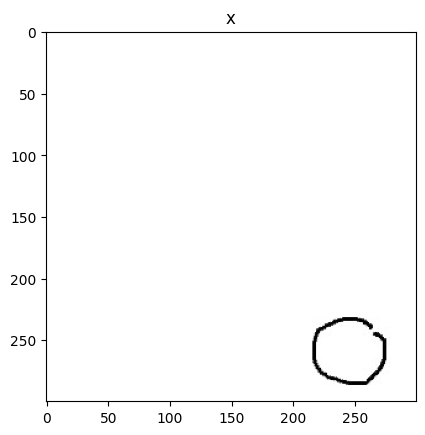

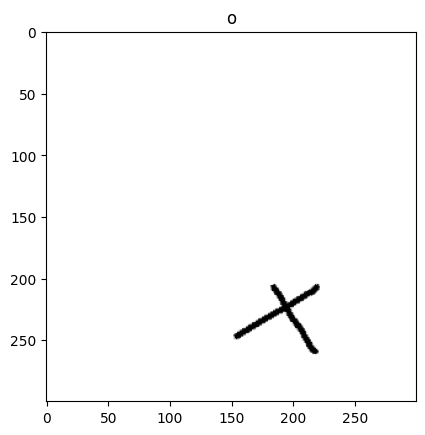

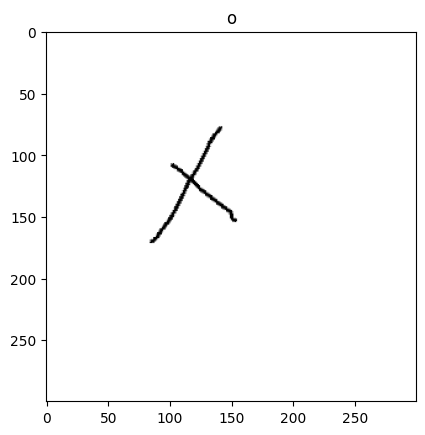

epoch(12 / 20)$ test_loss == 0.3825, test_acc == 0.9107


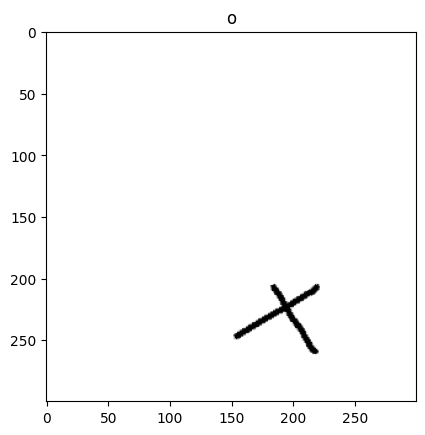

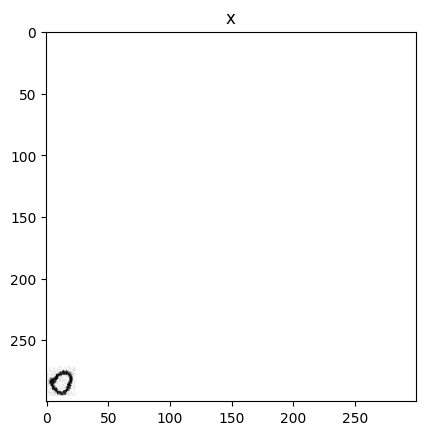

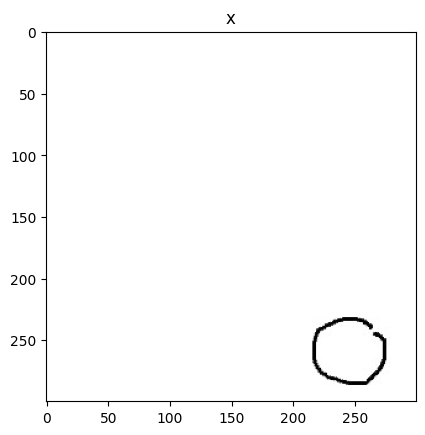

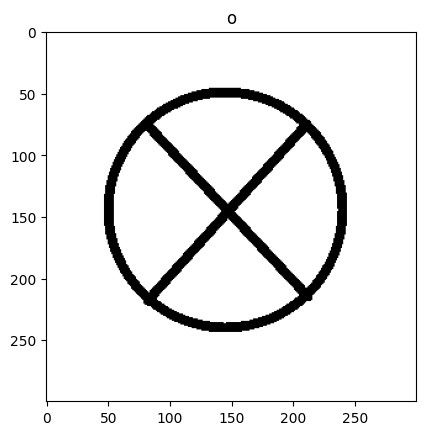

epoch(13 / 20)$ test_loss == 0.3367, test_acc == 0.9286


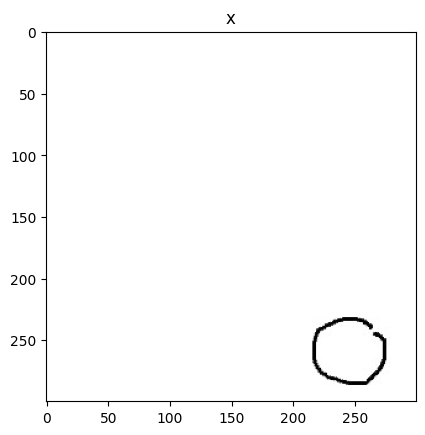

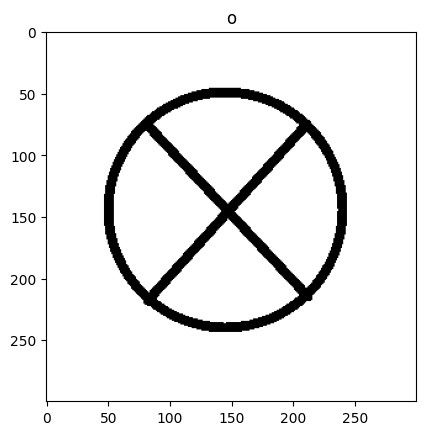

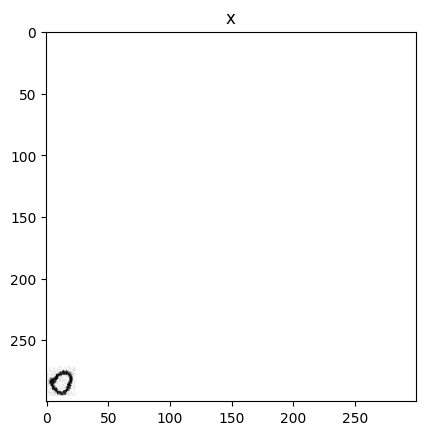

epoch(14 / 20)$ test_loss == 0.4685, test_acc == 0.9464


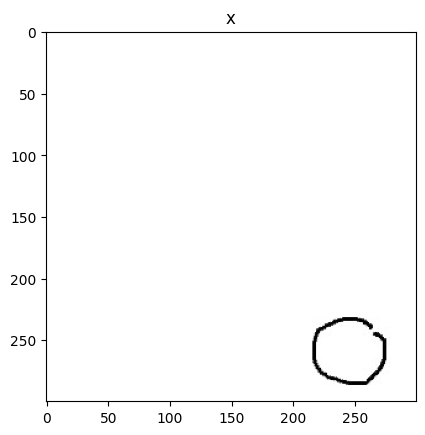

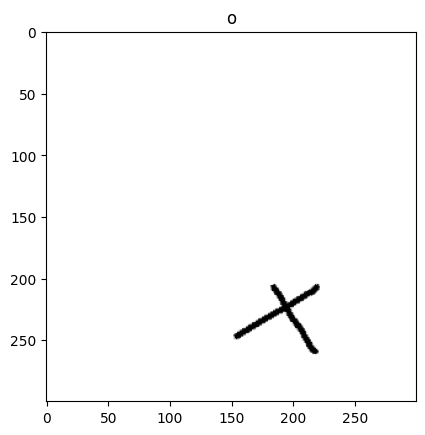

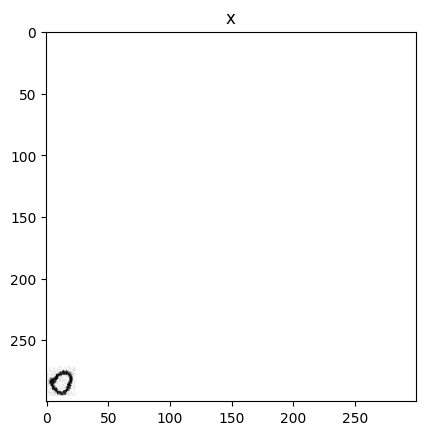

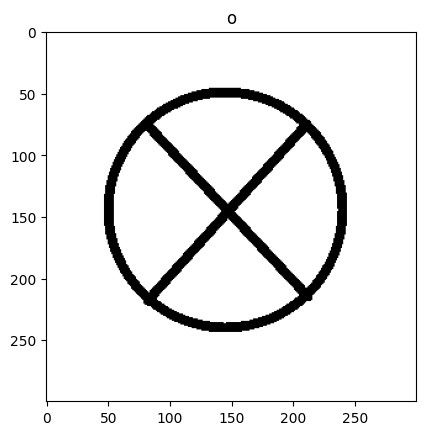

epoch(15 / 20)$ test_loss == 0.4533, test_acc == 0.9286


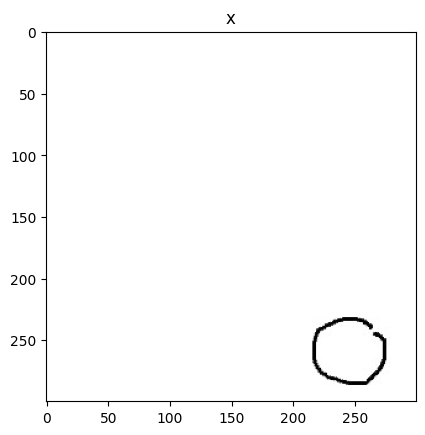

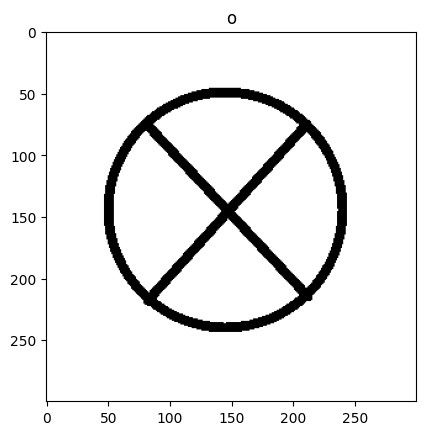

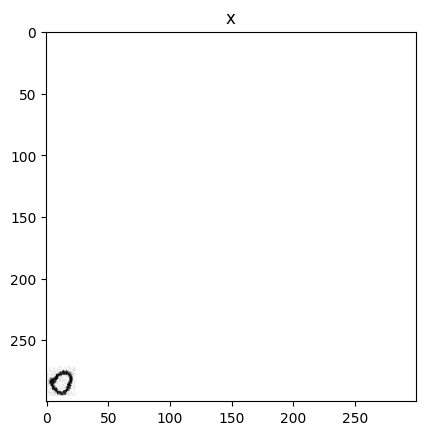

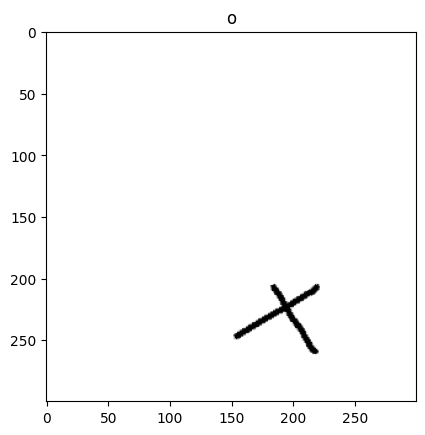

epoch(16 / 20)$ test_loss == 0.5117, test_acc == 0.9286


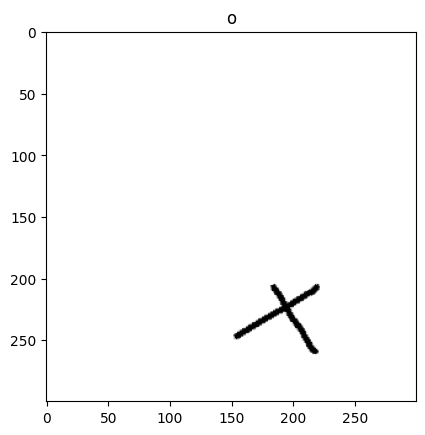

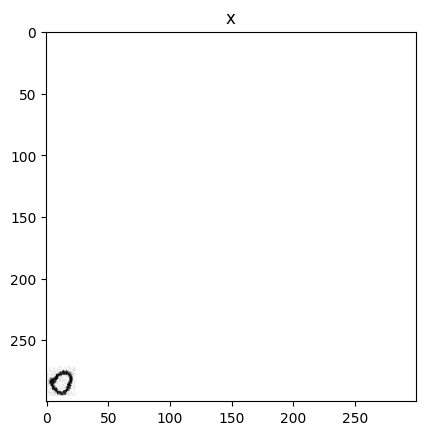

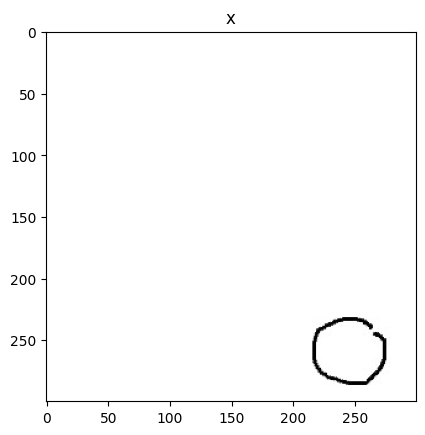

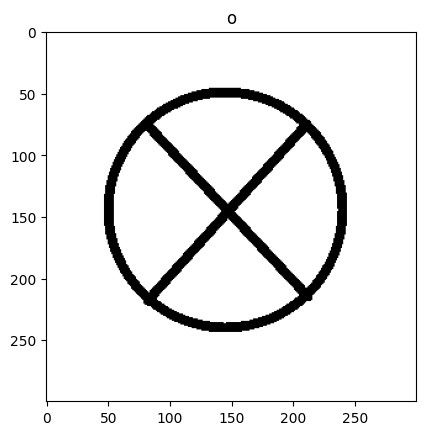

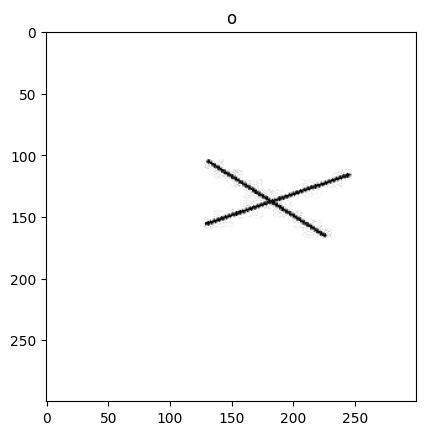

epoch(17 / 20)$ test_loss == 0.4014, test_acc == 0.9107


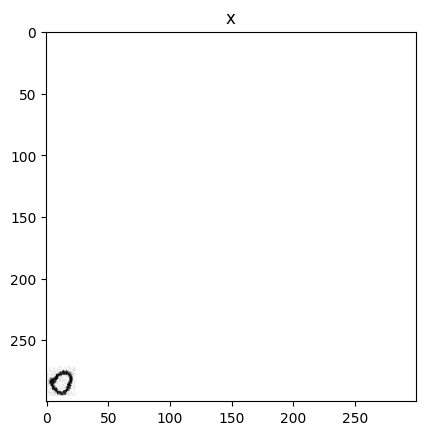

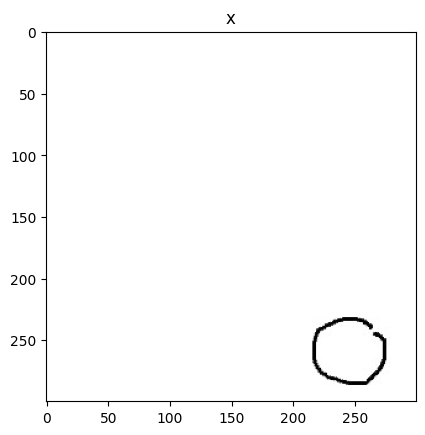

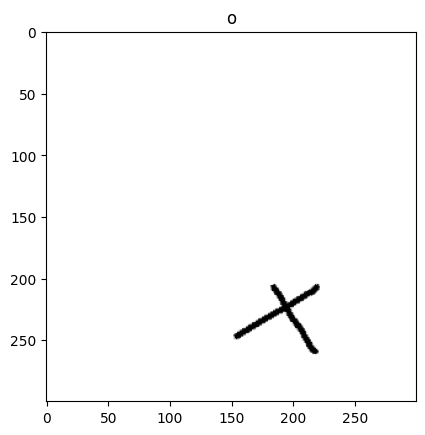

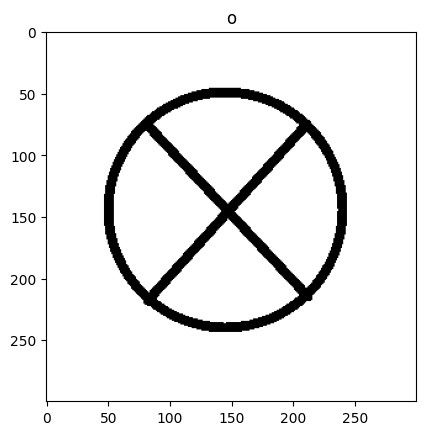

epoch(18 / 20)$ test_loss == 0.425, test_acc == 0.9286


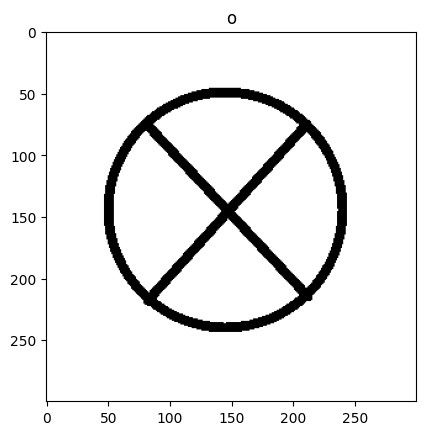

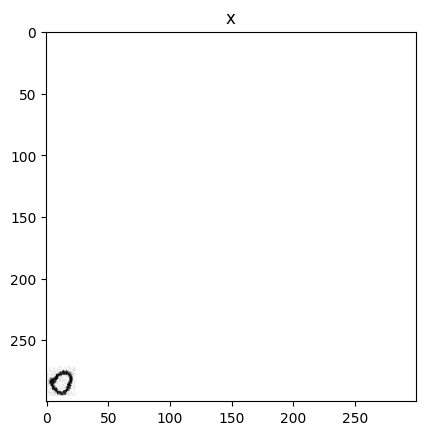

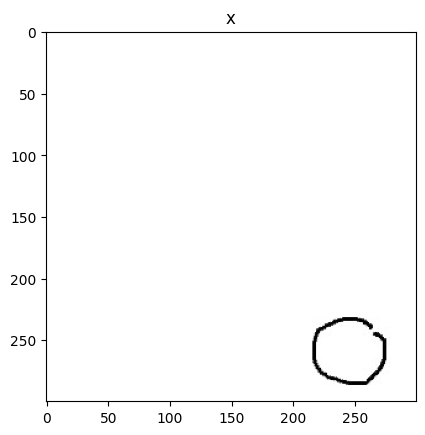

epoch(19 / 20)$ test_loss == 0.3195, test_acc == 0.9464


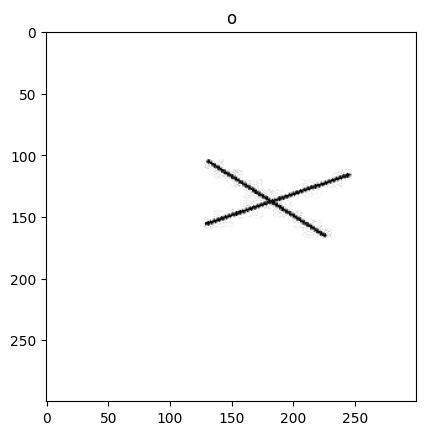

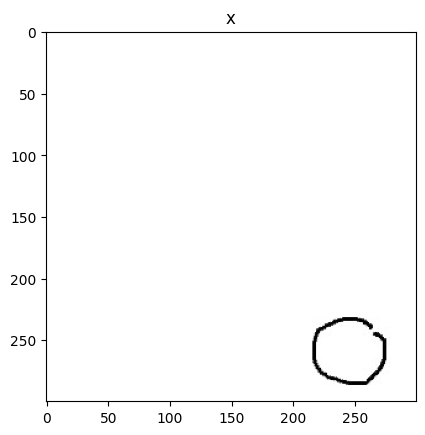

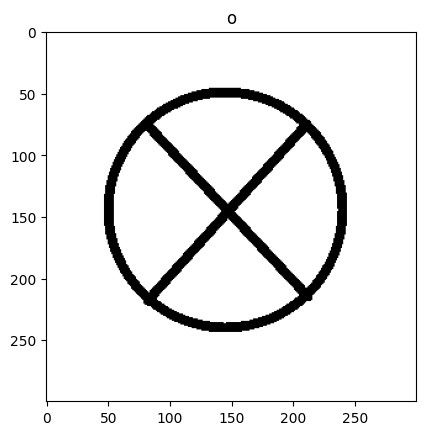

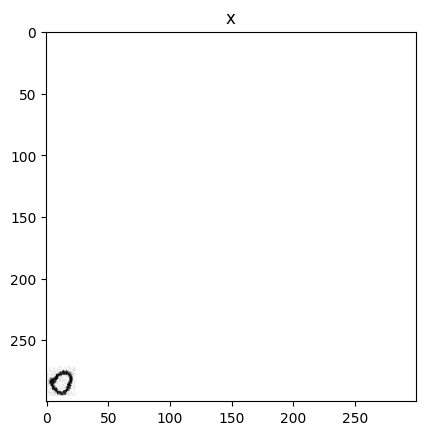

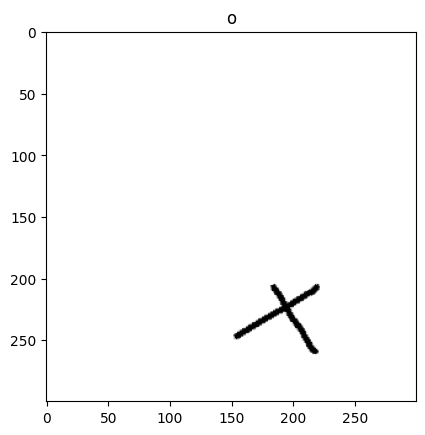

epoch(20 / 20)$ test_loss == 0.3909, test_acc == 0.9107
종료.


In [116]:
# 모델 train + test, 생성된 모델의 평균 loss & accuracy 출력
epochs = 20
learning_rate = 0.001
min_val_loss = 2.0

model = CNN1().to(device)
lf = nn.CrossEntropyLoss()
opt = torch.optim.Adam(model.parameters(), lr=learning_rate)

loss = []
acc = []

for t in range(epochs):
    #print(f"Epoch {t+1}\n-------------------------------")
    tr_loss = train_loop(trainloader, model, lf, opt, device)
    ts_acc, ts_loss = test_loop(testloader, model, lf, device)

    #tr_loss = round(tr_loss, 4)
    ts_acc = round(ts_acc, 4)
    ts_loss = round(ts_loss, 4)

    acc.append(ts_acc)
    loss.append(ts_loss)
    
    #if(t % 5 == 0 or t == 49):
    print("epoch({} / {})$ test_loss == {}, test_acc == {}".format(t + 1, epochs, ts_loss, ts_acc))
    
    # loss 값이 최저를 갱신할 때마다 모델을 저장
    if np.round(min_val_loss, 5) > np.round(ts_loss, 5):
        min_val_loss = ts_loss
        n_patience = 0
        torch.save(model.state_dict(), f'./best_model/0725/best_w_{t + 1}.pth')
        print('loss 최저치 갱신, 현재 모델 저장, best_w_{}.pth'.format(t + 1))
    else:
        n_patience += 1
    # 5번 연속으로 loss가 증가할 시 overfitting으로 판단, 종료
    #if n_patience > 5:
            #print(f"계속되는 loss 증가로 인한 종료. 마지막 epoch : {t + 1}")
            #break


    

print("종료.")

In [115]:
#gpu 캐시 비우기
torch.cuda.empty_cache()

In [40]:
md.eval()
ts_acc, ts_loss = test_loop(testloader, md, lf, device)
print("ts_acc : {} / ts_loss : {}".format(ts_acc, ts_loss))


ts_acc : 0.8393 / ts_loss : 0.2872


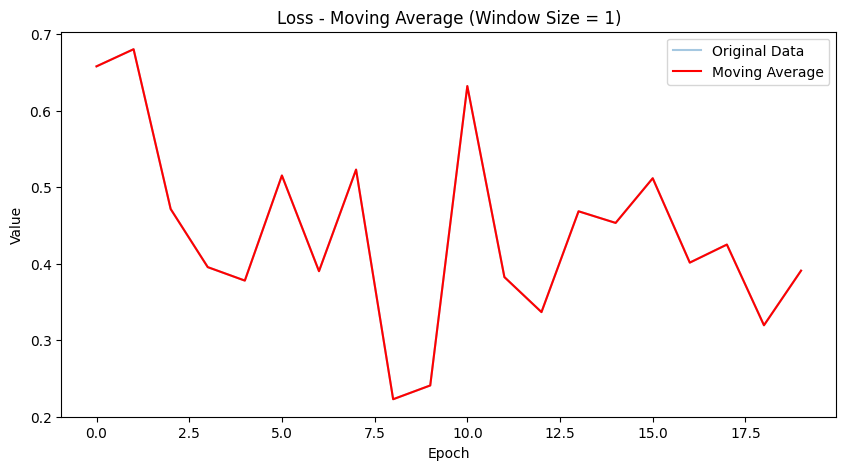

In [117]:
def moving_average(data, window_size):
    averages = []
    for i in range(len(data) - window_size + 1):
        window = data[i:i + window_size]
        window_average = sum(window) / window_size
        averages.append(window_average)
    return averages

def plot_moving_average(data, window_size):
    averages = moving_average(data, window_size)
    plt.figure(figsize=(10, 5))
    plt.plot(data, label='Original Data', alpha = 0.4)
    plt.plot(range(window_size - 1, len(data)), averages, label='Moving Average', color='red')
    plt.xlabel('Epoch')
    plt.ylabel('Value')
    plt.title(f'Loss - Moving Average (Window Size = {window_size})')
    plt.legend()
    plt.show()

plot_moving_average(loss, 1)

In [123]:
import sys
import numpy as np
import cv2


md = model # 모델 바로 쓰기

# 모델 불러오기
#PATH = "./best_model/0718/best_w_4.pth"
#md.load_state_dict(torch.load(PATH))
md.eval()

oldx = oldy = -1  # 좌표 기본값 설정
canvas_size = { 'x' : 300, 'y' : 330 }
#drawing_area_size = { 'x' : 300, 'y' : 300 }
button_size = { 'x' : 51, 'y': 30 }
# 버튼의 위치와 크기 (x, y, width, height)
#save_button_position = (canvas_size.x - button_size.x, canvas_size.y - button_size.y, button_size.x, button_size.y)  
save_pos = { 'x' :  0, 'y' : 0 }
reset_pos = {'x' : button_size['x'] + 5, 'y' : 0 }

# 흰색 컬러 영상 생성
img = np.full((330, 300, 1), 255, np.uint8)
result = ""

# 그림판은 OpenCV, 그러나 모델에서 사용하는 이미지는 PIL(Python ImageLoader)형식
# OpenCV는 BGR, PIL은 RGB순서라서 그 순서를 바꿔줘야 함
# 그래서 BGR2RGB 메소드 사용 - https://stackoverflow.com/a/48602446
def OpenCV2PIL(opencv_image):
    color_coverted = cv2.cvtColor(opencv_image, cv2.COLOR_BGR2RGB)
    pil_image = Image.fromarray(color_coverted)
    return pil_image

# 마우스 이벤트 함수
def on_mouse(event, x, y, flags, param):
    global oldx, oldy  # 밖에 있는 oldx, oldy 불러옴
    global result
    if event == cv2.EVENT_LBUTTONDOWN:  # 좌클릭
        oldx, oldy = x, y  # 최초 클릭 좌표 저장, 좌측 상단이 원점
        #print('EVENT_LBUTTONDOWN: %d, %d' % (x, y))  # 좌표 출력

        # Save버튼을 눌렀을 때
        if save_pos['x'] <= x <= save_pos['x'] + button_size['x'] and \
           save_pos['y'] <= y <= save_pos['y'] + button_size['y']:
            # 이미지를 (300, 300) 크기로 잘라서 저장 - 버튼이 위에 있으므로 (전체 - 버튼사이즈)
            cropped_img = img[button_size['y']:330, :300]
            pil_image=Image.fromarray(cv2.cvtColor(cropped_img, cv2.COLOR_BGR2RGB))
            # 디버그용 = 버튼 눌렀을때 잘린 이미지 확인
            #plt.imshow(pil_image)
            #width, height = pil_image.size
            #print(f'Width: {width}, Height: {height}')

            # 그린 이미지 예측하기
            trans_image = test_trans(pil_image).unsqueeze(0)
            with torch.no_grad():
                prd = md(trans_image.to(device))
                prediction = prd.max(1, keepdim=True)[1]

            if(prediction.item() == 0):
                result = 'O'
            else:
                result = 'X'
            result = "Maybe.. " + result
            print(result)
            # 결과 그리기 전에 결과창 비우기
            img[0:button_size["y"], 2*button_size["x"] + 6:300] = 255
            cv2.putText(img, result, (reset_pos['x'] + 85, reset_pos['y'] + 20), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 0), 1)
            cv2.imshow('image', img)
            
            
            
        # Reset버튼 눌렀을 때
        elif reset_pos['x'] <= x <= reset_pos['x'] + button_size['x'] and \
             reset_pos['y'] <= y <= reset_pos['y'] + button_size['y']:
            img[button_size['y'] + 1:330, :300] = 255  # 그림 영역을 흰색으로 덮어쓰기
            img[0:button_size["y"], 2*button_size["x"] + 6:300] = 255 # 결과창 흰색으로 덮어쓰기
            cv2.imshow('image', img)
            result = ""
            print('Canvas reset')

        
        
    elif event == cv2.EVENT_MOUSEMOVE:  # 마우스가 움직일 때 발생
        if flags & cv2.EVENT_FLAG_LBUTTON:  # ==를 쓰면 다른 키도 입력되었을 때 작동안하므로 &(and) 사용
            # cv2.circle(img, (x, y), 5, (0, 255, 0), -1)  # 단점이 빠르게 움직이면 끊김
            # -> cv2.line 이용
            # 마우스 클릭한 좌표에서 시작해서 마우스 좌표까지 그림
            if button_size['y']< y < 330:  # 그리기 영역을 넘어가지 않도록 함
                cv2.line(img, (oldx, oldy), (x, y), (0, 0, 0), 10, cv2.LINE_AA) # 괄호 없는 숫자가 선 굵기
                cv2.imshow('image', img)
                oldx, oldy = x, y  # 그림을 그리고 또 좌표 저장
                

# 저장 버튼
# rectangle(캔버스, 시작점좌표(좌상단), 반대쪽 모서리 좌표(우하단), (색), 선 굵기(-1이면 채우기))
cv2.rectangle(img, (save_pos['x'], save_pos['y']),
              (save_pos['x'] + button_size['x'], save_pos['y'] + button_size['y']),
              (12, 12, 12), -1)
# putText(캔버스, 문구, 시작점(글자 좌측 하단) 좌표, 폰트, 글자크기, 글자색, 굵기)
cv2.putText(img, 'Save', (save_pos['x'] + 5, save_pos['y'] + 20),
            cv2.FONT_HERSHEY_COMPLEX, 0.5, (255, 255, 255), 1)
# 초기화 버튼 
cv2.rectangle(img, (reset_pos['x'], reset_pos['y']),
              (reset_pos['x'] + button_size['x'], reset_pos['y'] + button_size['y']),
              (12, 12, 12), -1)
cv2.putText(img, 'Reset', (reset_pos['x'] + 5, reset_pos['y'] + 20),
            cv2.FONT_HERSHEY_COMPLEX, 0.5, (255, 255, 255), 1)

# 그림판 이름
cv2.namedWindow('image')

# 마우스 입력, namedWindow or imshow가 실행되어 창이 떠있는 상태에서만 사용 가능
# 마우스 이벤트가 발생하면 on_mouse 함수 실행
cv2.setMouseCallback('image', on_mouse, img)

# 영상 출력
cv2.imshow('image', img)
cv2.waitKey()

cv2.destroyAllWindows()


Maybe.. O
Canvas reset
Maybe.. X
Canvas reset


# 회고
<a href="https://icedpotato.notion.site/IMS-Lab-Study-16c1eb4810ec4301ac5d32dd4907d081" target="_blank">Notion 링크 </a>

(이론들 위주로 정리, 실습 내용은 아직 미기재)

드디어 한달간의 인공지능 스터디가 끝이 났다. ( 240701 ~ 240725 )

<p>&ensp;인공지능은 지난 학기(3-1)에 인공지능 강의를 수강했어서 어느 정도 기초는 알고 있었다고 생각했었는데, 그때는 머신러닝을 주로 배웠다면 이번에 다루는 것은 딥러닝이었고, 관련 자료를 계속 찾아보면서 인공지능이 엄청나게 넓고 깊은 분야임을 확실하게 체감하였다. 다행히도 둘 다 입문 느낌이라 겹치는 내용들(Loss Function, K-Fold 등)이 몇 가지 있어 그나마 스터디를 따라갈 수 있었지 않았나 싶다.</p>

<p>&ensp;또한 개발 관련한 스터디는 이번이 처음이어서 초반에 약간 쩔쩔맸던 일들이 많았는데, 그래도 이렇게 마지막으로 완성된 결과물을 보고 나면 지난 한 달간의 노력이 그래도 헛되진 않았다는 생각도 드는 것 같다.</p>

## 배운 것들
### 1) 딥러닝 개요
    -> 딥러닝이란, 합성곱 연산, 과적합, 전처리 등
### 2) MLP, CNN 이론
### 3) 활성함수, KFold
### 4) MLP 모델 구현 using PyTorch
### 5) CNN 모델 구현 using PyTorch
### 6) 하이퍼파라미터 조정 등 모델 개선
### 7) 모델 평가용 GUI(그림판) 구현

## 느낀 점
     > 직접 정보 찾아가면서 Notion에 정리하고 코드를 작성했는데, 첫 주까지는 시간을 많이 소모했으나 점점 익숙해지면서 훨씬 효율적으로 진행할 수 있었다. 그리고 기존의 강의식 방법보다는 배우는 양이 적으나 내가 검색하고 그 내용을 바탕으로 정리를 하다 보니 쉽게 장기기억으로 저장되는 느낌도 받았다. 
     > 이전에도 학교 강의를 들을 때 강의 자료를 그대로 사용하지 않고 내가 이해한 내용을 한번 더 메모하는 식으로 공부를 했었는데, 이번 스터디를 진행하면서 확실하게 깨닫게 되었다. 역시 나한테는 눈으로 보고 외우기보다는 내 방식대로, 내가 이해한 내용을 손으로 직접 적는 방식이 훨씬 효율이 좋은 것 같다.
     > 여담으로, 위에서 만든 CNN 모델의 경우 아쉽게도 모서리쪽 동그라미라던가, 가운데에 굉장히 작은 동그라미와 같은 몇몇 케이스들은 제대로 분류하지 못하는 문제가 존재한다. 아무래도 데이터 수가 부족해서(전체 280장, O: 140, X: 140) 그런 것으로 추정되며, 훈련 데이터들을 복제한 후 전처리 과정에서 무작위 로테이션, 수직/수평 반전 등의 요소를 추가하면 정확도 및 일반화 성능을 더 끌어올릴 수 있지 않을까.. 하는 생각도 든다. 언?젠가 여유 시간이 생긴다면..

## 앞으로?
    지금까지 실습한 내용(과정은 간략하게, 결과물 위주로)들을 정리해서 Notion에 업로드 하고, 앞으로 새로 배운 내용들을 여기에 쭉 기록하다 보면 꽤 괜찮은 발자취? || 역사를 남길 수 있을 것 같다.

    

# 여담
### 아직도 기억나는 <del>샷건</del>에러 모먼트
#### 배경)
    > 구글 Colab으로 모델을 학습하는 도중 런타임 할당량이 전부 소진
    > 24시간을 넘게 기다려야 복구가 되는 상황
    > 결국 집에있는 컴퓨터(Jupyter Notebook)로 실행 환경 변경

#### 1)
    > GPU연산을 위해 cuda를 설치하는 등 GPU 연산을 위한 환경을 세팅했으나..
    > gpu를 인식하지 못함(자꾸 cpu로만 연산) -> 수많은 구글링 끝에 어떻게 해결
    > 이제 Colab에서 작성한 코드 그대로 옮기고, 환경에 맞게 데이터 경로 등 수정
#### 2)
    > 이제 테스트 해보려는데 갑자기 expectd all tensors 어쩌고 에러 발생
    > 분명 모델들 다 .to(device)로 gpu로 옮겼는데;
    > 알고보니까 모델에 학습/검증시킬 데이터들(DataLoader)도 gpu에 마운트해야함
    > 모델 내부에서 X.to(device), y.to(device) 추가해줌으로써 해결
#### 3)
    > 하이퍼파라미터, 모델의 히든 레이어 구성 조합을 바꿔가면서 계속 테스트
    > 갑자기 cuda error device-side assert triggered 에러 발생
    > 잘되다가 이 에러 뜨고 난 이후부터는 뭔짓을 해도 안사라짐 -> 커널 초기화가 유일한 해결책
    > 검색해봐도 이건 수많은 가능성들이 존재
    > 검색해서 나오는 해결 사례들 4~6가지 시도했으나 안맞음
    > 나중에서야 찾게되는데 바로 gpu vram 초과하는 경우에도 저 에러가 뜬다는 사실을 발견
    > 작업관리자 켜서 vram 사용량을 보니 모델 학습이 끝나도 vram 사용량이 줄어들지 않음을 확인
    > 결국 torch.cuda.empty_cache() 메소드를 통해서 gpu 캐시를 비우는 방식을 사용하여 해결
    